### Import

In [1]:
#Imports

import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import scipy.integrate
import scipy.signal
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.interpolate import UnivariateSpline
from scipy.optimize import leastsq

%matplotlib inline

# Use custom style
plt.style.use("../01_Style/FigureTemplate_ITWM.mplstyle")

### Parsing & Wrangling methods

In [2]:
def datawrangling(path, reduction=0):
    
    #Initiating DataFrame
    global df0
    df0 = pd.read_csv(path,names=['time', 'voltage'])
    
    # Calculating time step
    global timestep
    timestep = df0['time'][1]-df0['time'][0]
    #timestep = max(df0['time'])/(len(df0['time'])-1)
    
    # Calculating bandwidth
    global bandwidth
    bandwidth = 1/timestep
    
    if reduction > 0:
        # Reducing size of dataframe
        condition_low = df0['time'] >= timestep * 0
        condition_high = df0['time'] < timestep * (len(df0['time'])*(1-reduction))
        df_red = df0[condition_low]
        df_red = df_red[condition_high]
        
        # Time shift (not necessary and takes a lot of time)
        #df_red['time'] = df_red['time'].transform(lambda x: x - df0['time'][0])
        
    else:
        # Time shift
        #df0['time'] = df0['time'].transform(lambda x: x - df0['time'][0])
        df_red = df0    
        
    return df_red

In [3]:
def calibration(alpha):
    # Calibration: Volt to seconds
    df_red['jitter'] = df_red['voltage'].transform(lambda x: alpha*x)

In [4]:
def timingjitter(f_den, Jxx_den, bp_cut_on_list = [], index=0, plot=False):
    
    df_timingJitter = pd.DataFrame()
    timingJitter_list = []

    # Timing jitter calculation II
    #f_den, Jxx_den = sp.signal.welch(df_red['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg)

    #for bp_cut_on in [0, 1e3, 1e4, 1e5]:
    for bp_cut_on in bp_cut_on_list:
        # Bandpass indices
        f_window = max(f_den)/len(f_den)
        start = int(round(bp_cut_on/f_window))
        end = int(round(1e6/f_window))
        
        # Calculate timing jitter
        timingJitter_list.append(np.sqrt(sp.integrate.trapz(Jxx_den[start:end], x=f_den[start:end], axis=-1)))
        
    df_timingJitter[index] = timingJitter_list
    
    df_timingJitter = df_timingJitter.T
    df_timingJitter = df_timingJitter.rename(columns={0: '0-1MHz', 1: '1kHz-1MHz', 2: '10kHz-1MHz', 3: '50kHz-1MHz', 4: '100kHz-1MHz'}) 
    
    return df_timingJitter

In [5]:
def plotplt(df_red, alpha, fs, nperseg, Jitter=False, JSD=False, JS=False):
    if Jitter == True:
        # Timing jitter calculation 
        # Fourier filtering of voltage signal, backtransformation, and calibration

        # FFT
        rf_fft = sp.fftpack.fft(df_red['voltage'])
        rf_psd = np.abs(rf_fft)**2
        rf_fftfreq = sp.fftpack.fftfreq(n=rf_psd.size, d=timestep)

        # Filtering
        condition_rf_bandpass_low = np.abs(rf_fftfreq) <= 1e4 
        condition_rf_bandpass_high = np.abs(rf_fftfreq) >= 1e6

        rf_fft_filtered = rf_fft.copy()
        rf_fft_filtered[condition_rf_bandpass_low] = 0
        rf_fft_filtered[condition_rf_bandpass_high] = 0

        # Back transformation
        df_red['voltage_filtered'] = np.real(sp.fftpack.ifft(rf_fft_filtered))

        # Calibration
        df_red['jitter_filtered'] = df_red['voltage_filtered'].transform(lambda x: alpha*x)
        
        # Figures
        plt.plot(df_red['time'], df_red['jitter'], 'b-', lw=0.03)
        plt.plot(df_red['time'], df_red['jitter_filtered'], 'r-', lw=0.08)
        plt.rcParams["figure.figsize"] = (20,5)
        plt.xlabel('Time / s')
        plt.ylabel('Jitter / s')
        plt.title("Jitter signal over time")
        
        plt.show()
        
    if JSD == True:
        f_den, Jxx_den = sp.signal.welch(df_red['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg)
        
        # Figure
        plt.plot(f_den, Jxx_den, linewidth=0.1, marker='o', markersize=0.1, color='b')
        plt.rcParams["figure.figsize"] = (20,5)
        plt.xlim([1e0,1e7])
        plt.ylim([1e-9,1e3])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Frequency / Hz')
        plt.ylabel('Jitter spectral density / fs**2/Hz')
        plt.title("Jitter spectral density")
       
        plt.show()
        
    if JS == True:
        f_spec, Jxx_spec = sp.signal.welch(df_red['jitter'].transform(lambda x: x*1e15), fs, scaling='spectrum', nperseg=nperseg)
        
        # Figure
        plt.plot(f_spec, np.sqrt(Jxx_spec), linewidth=0.1, marker='o', markersize=0.1, color='b')
        plt.rcParams["figure.figsize"] = (20,5)
        plt.xlim([1e0,1e7])
        plt.ylim([1e-9,0.5e2])
        plt.xscale('log')
        #plt.yscale('log')
        plt.xlabel('Frequency / Hz')
        plt.ylabel('Jitter spectrum / fs')
        plt.title("Jitter spectrum")
       
        plt.show()

### Run 

In [7]:
# Calibration constant alpha delta t / delta U
alpha_15 = 2.610*1e-12/1.47 # / s/V 
alpha_10 = 2.610*1e-12/1.65 # / s/V 
alpha_5 = 2.610*1e-12/1.36 # / s/V 
alpha_0 = 2.610*1e-12/1.22 # / s/V 

#fs = bandwidth
nperseg = 2500004 #len(df_red['jitter'])

path_15 = 'LaseLock/15nm/15nm_lase_0,10mm_03.csv'
path_10 = 'LaseLock/10nm/10nm_lase_0,04mm_09.csv'
path_5 = 'LaseLock/5nm/5nm_lase_0,10mm_05.csv'
path_0 = 'LaseLock/0nm/0nm_lase_0,10mm_08.csv'

In [8]:
class Laser:
    def __init__(self, filterBw, position, numbers, alpha):
        # Path definitions
        self.folder = '../01_Data/LaseLock'
        self.alpha = alpha
        
        for i in numbers:
            self.path = self.folder+'/'+filterBw+'/'+filterBw+'_lase_'+position+'_'+'0'+str(i)+'.csv'

            # Reading, Parsing, Wrangling & Analysis
            self.dfs = []
            self.dens = []
            self.df = datawrangling(self.path, 0.0)
            self.df['jitter'] = self.df['voltage'].transform(lambda x: self.alpha*x)
            self.dfs.append(self.df)
            self.dens.append(sp.signal.welch(self.df['jitter'].transform(lambda x: x*1e15), bandwidth, scaling='density', nperseg=nperseg/5))
            
            self.Jxx_den_mean = self.dens[0][1]-self.dens[0][1]
            for i in range(len(self.dens)):
                self.Jxx_den_mean += self.dens[i][1] 
            self.Jxx_den_mean = self.Jxx_den_mean/len(numbers)
            
            self.f_den = sp.signal.welch(self.dfs[0]['jitter'].transform(lambda x: x*1e15), bandwidth, scaling='density', nperseg=nperseg/5)[0]
            self.timingJitter = timingjitter(self.f_den, self.Jxx_den_mean, bp_cut_on_list=[0, 1e3, 1e4, 5e4, 1e5], index=0, plot=False)

In [9]:
alpha_0 = 2.610*1e-12/1.22 # / s/V 
nperseg = 2500004 #len(df_red['jitter'])

laser_0nm = Laser('0nm', '0,10mm', range(1,5), alpha_0)

In [10]:
alpha_5 = 2.610*1e-12/1.36 # / s/V 
laser_5nm = Laser('5nm', '0,10mm', range(1,5), alpha_5)

In [11]:
alpha_10 = 2.610*1e-12/1.65 # / s/V 
laser_10nm = Laser('10nm', '0,04mm', ['2','3','7','8'], alpha_10)

In [13]:
alpha_15 = 2.610*1e-12/1.47 # / s/V 
laser_15nm = Laser('15nm', '0,10mm', range(1,5), alpha_15)

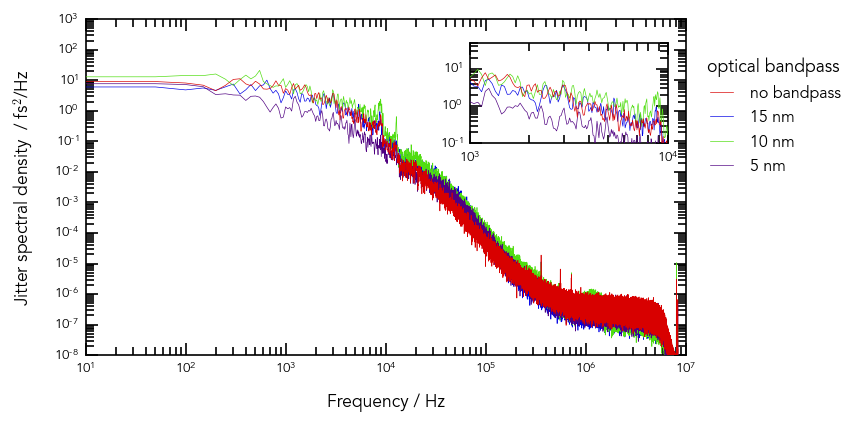

In [14]:
# Figure

# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

plt.style.use("../01_Style/FigureTemplate_ITWM.mplstyle")

# Add two axes objects to create an inset figure
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0.64, 0.63, 0.33, 0.30])

ax1.plot(laser_0nm.f_den, laser_0nm.Jxx_den_mean, linewidth=0.4, label='no bandpass', zorder=8)
ax1.plot(laser_15nm.f_den, laser_15nm.Jxx_den_mean, linewidth=0.4, label='15 nm', zorder=5)
ax1.plot(laser_10nm.f_den, laser_10nm.Jxx_den_mean, linewidth=0.4, label='10 nm', zorder=6)
ax1.plot(laser_5nm.f_den, laser_5nm.Jxx_den_mean, linewidth=0.4, label='5 nm', zorder=7)

ax2.plot(laser_0nm.f_den, laser_0nm.Jxx_den_mean, linewidth=0.4, label='no bandpass', zorder=8)
ax2.plot(laser_15nm.f_den, laser_15nm.Jxx_den_mean, linewidth=0.4, label='15 nm', zorder=5)
ax2.plot(laser_10nm.f_den, laser_10nm.Jxx_den_mean, linewidth=0.4, label='10 nm', zorder=6)
ax2.plot(laser_5nm.f_den, laser_5nm.Jxx_den_mean, linewidth=0.4, label='5 nm', zorder=7)


#ax1.rcParams["figure.figsize"] = (20,5)
ax1.set_xlim([1e1,1e7])
ax1.set_ylim([1e-8,1e3])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Frequency / Hz', fontsize=10.5)
ax1.set_ylabel('Jitter spectral density  / fs$^2$/Hz', fontsize=10.5)
#ax1.set_title("Jitter spectral density - 5nm - LaseLock")
plt.legend(bbox_to_anchor=(1.95, 1), title='optical bandpass', title_fontsize=10.5, markerscale=10.0)

ax2.set_xlim([1e3,1e4])
ax2.set_ylim([1e-1,5e1])
ax2.set_xscale('log')
ax2.set_yscale('log')

#plt.savefig('../01_Plots/BandpassFiltering_mean.pdf', format='pdf')
#plt.savefig('../01_Plots/BandpassFiltering_mean.png', format='png')

plt.show()

In [15]:
print(laser_0nm.timingJitter)
print("\n")
print(laser_15nm.timingJitter)
print("\n")
print(laser_10nm.timingJitter)
print("\n")
print(laser_5nm.timingJitter)

       0-1MHz   1kHz-1MHz  10kHz-1MHz  50kHz-1MHz  100kHz-1MHz
0  137.302075  108.717277   20.050849    3.495144      1.62312


       0-1MHz   1kHz-1MHz  10kHz-1MHz  50kHz-1MHz  100kHz-1MHz
0  123.891413  100.812412    26.32905    5.337325     1.711592


       0-1MHz   1kHz-1MHz  10kHz-1MHz  50kHz-1MHz  100kHz-1MHz
0  167.593957  132.047061   32.433958    5.566873     2.218879


      0-1MHz  1kHz-1MHz  10kHz-1MHz  50kHz-1MHz  100kHz-1MHz
0  77.833013  56.832918   18.126374    4.836555     1.767045


## PIEZO & CO. --> Doesn't run since the raw data is missing (too big for this repo)

In [7]:
def Jxx_den_mean(path, alpha):    
    paths = []
    for i in range(1,4):
        paths.append(path[:-5]+str(i)+'.csv')

    dfs_red = []
    for i in range(len(paths)):
        dfs_red.append(datawrangling(paths[i], 0.0))

    for i in range(len(paths)):
        dfs_red[i]['jitter'] = dfs_red[i]['voltage'].transform(lambda x: alpha*x)
        
    nperseg= len(dfs_red[0]['jitter'])
    bandwidth = 1/(dfs_red[0]['time'][1]-dfs_red[0]['time'][0])
    
    dens= []
    for i in range(len(paths)):
        dens.append(sp.signal.welch(dfs_red[i]['jitter'].transform(lambda x: x*1e15), bandwidth, scaling='density', nperseg=nperseg)[1])
        #dens.append(sp.signal.welch(dfs_red[i]['voltage'], fs, scaling='density', nperseg=nperseg))

    Jxx_den_mean = dens[1]-dens[0]
    for i in range(len(paths)):
        Jxx_den_mean += dens[i]
    Jxx_den_mean = Jxx_den_mean/len(paths)
    
    f_den = sp.signal.welch(dfs_red[0]['jitter'].transform(lambda x: x*1e15), bandwidth, scaling='density', nperseg=nperseg)[0]
    
    return (f_den, Jxx_den_mean)

In [31]:
def Jxx_den_mean_2(path, alpha):    
    paths = []
    for i in range(1,9):
        paths.append(path[:-5]+str(i)+'.csv')

    dfs_red = []
    for i in range(len(paths)):
        dfs_red.append(datawrangling(paths[i], 0.0))

    for i in range(len(paths)):
        dfs_red[i]['jitter'] = dfs_red[i]['voltage'].transform(lambda x: alpha*x)
        
    nperseg= len(dfs_red[0]['jitter'])
    bandwidth = 1/(dfs_red[0]['time'][1]-dfs_red[0]['time'][0])
    
    dens= []
    for i in range(len(paths)):
        dens.append(sp.signal.welch(dfs_red[i]['jitter'].transform(lambda x: x*1e15), bandwidth, scaling='density', nperseg=nperseg)[1])
        #dens.append(sp.signal.welch(dfs_red[i]['voltage'], fs, scaling='density', nperseg=nperseg))

    Jxx_den_mean = dens[1]-dens[0]
    for i in range(len(paths)):
        Jxx_den_mean += dens[i]
    Jxx_den_mean = Jxx_den_mean/len(paths)
    
    f_den = sp.signal.welch(dfs_red[0]['jitter'].transform(lambda x: x*1e15), bandwidth, scaling='density', nperseg=nperseg)[0]
    
    return (f_den, Jxx_den_mean)

In [134]:
alpha_lase_slap=2.610*1e-12/1.65

f_den_slap, Jxx_den_slap_mean = Jxx_den_mean_2('/Users/felixjeskoparies/Desktop/JitterAnalysis/SlapLock/5nm/5nm_slap_0,10mm_01.csv', alpha_lase_slap)
f_den_lase, Jxx_den_lase_mean = Jxx_den_mean_2('/Users/felixjeskoparies/Desktop/JitterAnalysis/LaseLock/5nm/5nm_lase_0,10mm_01.csv', alpha_lase_slap)

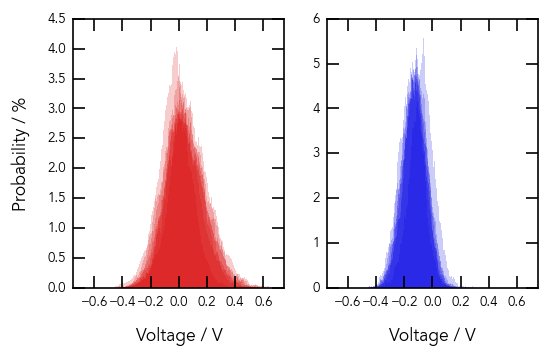

In [157]:
path_slap = '/Users/felixjeskoparies/Desktop/JitterAnalysis/SlapLock/5nm/5nm_slap_0,10mm_01.csv'
path_lase = '/Users/felixjeskoparies/Desktop/JitterAnalysis/LaseLock/5nm/5nm_lase_0,10mm_01.csv'

fig, ax = plt.subplots(1,2)
plt.style.use('ITWM')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i in range(1,9):
    ax[0].hist(datawrangling(path_slap[:-5]+str(i)+'.csv', 0.0)['voltage'], 500, facecolor=colors[0], alpha=0.2, linewidth=0.0, density=True)
    ax[1].hist(datawrangling(path_lase[:-5]+str(i)+'.csv', 0.0)['voltage'], 500, facecolor=colors[1], alpha=0.2, linewidth=0.0, density=True)
    
for i in [0,1]:
    ax[i].set_xlim(-0.75,0.75)
    ax[i].set_xlabel('Voltage / V', fontsize=10.5)
    ax[0].set_ylabel('Probability / %', fontsize=10.5)
    
plt.savefig("Histogram_Slap_Lase")
plt.savefig("Histogram_Slap_Lase.pdf", format='pdf')


In [1]:
# Figure

# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

plt.style.use('ITWM')

# Add two axes objects to create an inset figure
ax1 = fig.add_axes([0, 0, 1, 1])
#ax2 = fig.add_axes([0.64, 0.63, 0.33, 0.30])

ax1.plot(f_den_slap, Jxx_den_slap_mean, linewidth=0.4, label="ECOPS", zorder=-2)
ax1.plot(f_den_lase, Jxx_den_lase_mean, linewidth=0.4, label="LaseLock", zorder=-1)

#ax2.plot(f_den_slap, Jxx_den_slap_mean, linewidth=0.4, label="ECOPS", zorder=-2)
#ax2.plot(f_den_lase, Jxx_den_lase_mean, linewidth=0.4, label="LaseLock", zorder=-1)

#ax1.rcParams["figure.figsize"] = (20,5)
ax1.set_xlim([1e1,5e6])
ax1.set_ylim([1e-8,1e3])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Frequency / Hz', fontsize=10.5)
ax1.set_ylabel('Jitter spectral density  / fs$^2$/Hz', fontsize=10.5)
#ax1.set_title("Jitter spectral density - 5nm - LaseLock")
plt.legend(bbox_to_anchor=(1.25, 1), title='Stabilization', title_fontsize=10.5, markerscale=10.0)

#ax2.set_xlim([1e4,1e5])
#ax2.set_ylim([1e-1,5e1])
#ax2.set_xscale('log')
#ax2.set_yscale('log')

plt.savefig('Lase_vs_Slap_mean_5nm_0,10mm.png', format='png', dpi=600)
plt.savefig('Lase_vs_Slap_mean_5nm_0,10mm.pdf', format='pdf')

plt.show()

NameError: name 'plt' is not defined

In [9]:
alpha_piezo_300 = 1.171*1e-12/0.442 #s/V

f_den_300Hz_1mV, Jxx_den_300Hz_1mV_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,001Vamp_0,0052Voff_300Hz_01.csv', alpha_piezo_300)
f_den_300Hz_10mV, Jxx_den_300Hz_10mV_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,010Vamp_0,019Voff_300Hz_01.csv', alpha_piezo_300)
f_den_300Hz_65mV_2, Jxx_den_300Hz_65mV_2_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,065Vamp_0,245Voff_300Hz_01.csv', alpha_piezo_300)

f_den_300Hz_65mV, Jxx_den_300Hz_65mV_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,065Vamp_0,715Voff_300Hz_01.csv', alpha_piezo_300)
f_den_300Hz_115mV, Jxx_den_300Hz_115mV_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,115Vamp_1,425Voff_300Hz_01.csv', alpha_piezo_300)
f_den_300Hz_365mV, Jxx_den_300Hz_365mV_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,365Vamp_1,955Voff_300Hz_01.csv', alpha_piezo_300)
f_den_300Hz_390mV, Jxx_den_300Hz_390mV_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,390Vamp_1,45Voff_300Hz_01.csv', alpha_piezo_300)
f_den_300Hz_1000mV, Jxx_den_300Hz_1000mV_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_1,0Vamp_1,76Voff_300Hz_01.csv', alpha_piezo_300)


f_den_300Hz_4000mV, Jxx_den_300Hz_4000mV_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_4,0Vamp_4,8Voff_300Hz_01.csv', alpha_piezo_300)
f_den_300Hz_8000mV, Jxx_den_300Hz_8000mV_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_8,0Vamp_10,2Voff_300Hz_01.csv', alpha_piezo_300)

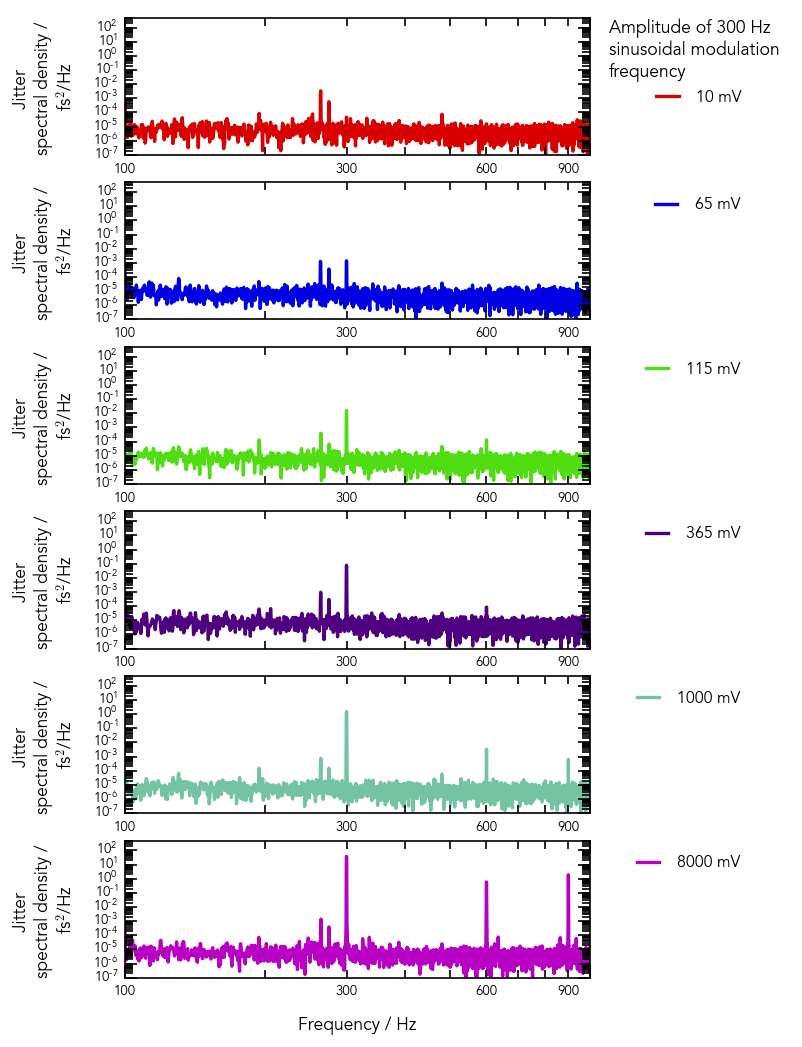

In [83]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import IndexFormatter

def format_func(value, tick_number):
# The function should take in two inputs (a tick value x and a position pos), and return a string containing the corresponding tick label.
    if value == 100:
        return "100"
    elif value == 300:
        return "300"
    elif value == 600:
        return "600"
    elif value == 900:
        return "900"
    else:
        return ""

fig, ax = plt.subplots(6,1, figsize=(5,10))
plt.style.use('ITWM')

ax[0].plot(f_den_300Hz_10mV, Jxx_den_300Hz_10mV_mean, color=colors[0], label='10 mV')
ax[1].plot(f_den_300Hz_65mV_2, Jxx_den_300Hz_65mV_2_mean, color=colors[1], label='65 mV')
ax[2].plot(f_den_300Hz_115mV, Jxx_den_300Hz_115mV_mean, color=colors[2], label='115 mV')
#ax[3].plot(f_den_300Hz_365mV, Jxx_den_300Hz_365mV_mean)
ax[3].plot(f_den_300Hz_365mV, Jxx_den_300Hz_365mV_mean, color=colors[3], label='365 mV')
ax[4].plot(f_den_300Hz_1000mV, Jxx_den_300Hz_1000mV_mean, color=colors[4], label='1000 mV')
#ax[5].plot(f_den_300Hz_4000mV, Jxx_den_300Hz_4000mV_mean)
ax[5].plot(f_den_300Hz_8000mV, Jxx_den_300Hz_8000mV_mean, color=colors[5],label='8000 mV')

for i in range(6):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlim(1e2,1e3)
    ax[i].set_ylim(1e-7,5e2)
    
    ax[i].set_xticklabels([])
    ax[i].xaxis.set_minor_formatter(plt.FuncFormatter(format_func))
    ax[i].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    
    #labels_major = [item.get_text() for item in ax[i].get_xticklabels()]
    #ax[i].set_xticklabels(labels)
    #x[i].set_xticklabels([])
    ax[i].set_ylabel('Jitter \nspectral density / \nfs$^2$/Hz', fontsize=10.5)
    ax[i].legend(bbox_to_anchor=(1.355,1))
    
ax[5].set_xlabel('Frequency / Hz', fontsize=10.5)
ax[0].legend(title='Amplitude of 300 Hz \nsinusoidal modulation \nfrequency', title_fontsize=10.5, bbox_to_anchor=(1.45,1.1))   

plt.savefig("Piezo_modulation_JSD")
plt.savefig("Piezo_modulation_JSD.pdf", format='pdf')

In [85]:
alpha_piezo = 1.940*1e-12/0.466 #s/V

f_den_100Hz, Jxx_den_100Hz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_0,1kHz_01.csv', alpha_piezo)
f_den_200Hz, Jxx_den_200Hz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_0,2kHz_01.csv', alpha_piezo)
f_den_300Hz, Jxx_den_300Hz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_0,3kHz_01.csv', alpha_piezo)
f_den_400Hz, Jxx_den_400Hz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_0,4kHz_01.csv', alpha_piezo)
f_den_500Hz, Jxx_den_500Hz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_0,5kHz_01.csv', alpha_piezo)
f_den_600Hz, Jxx_den_600Hz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_0,6kHz_01.csv', alpha_piezo)
f_den_700Hz, Jxx_den_700Hz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_0,7kHz_01.csv', alpha_piezo)
f_den_800Hz, Jxx_den_800Hz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_0,8kHz_01.csv', alpha_piezo)
f_den_900Hz, Jxx_den_900Hz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_0,9kHz_01.csv', alpha_piezo)

In [86]:
f_den_1kHz, Jxx_den_1kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_1,0kHz_01.csv', alpha_piezo)
f_den_2kHz, Jxx_den_2kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_2,0kHz_01.csv', alpha_piezo)
f_den_3kHz, Jxx_den_3kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_3,0kHz_01.csv', alpha_piezo)
f_den_4kHz, Jxx_den_4kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_4,0kHz_01.csv', alpha_piezo)
f_den_5kHz, Jxx_den_5kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_5,0kHz_01.csv', alpha_piezo)
f_den_6kHz, Jxx_den_6kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_6,0kHz_01.csv', alpha_piezo)
f_den_7kHz, Jxx_den_7kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_7,0kHz_01.csv', alpha_piezo)
f_den_8kHz, Jxx_den_8kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_8,0kHz_01.csv', alpha_piezo)
f_den_9kHz, Jxx_den_9kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_9,0kHz_01.csv', alpha_piezo)

In [87]:
f_den_10kHz, Jxx_den_10kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_10,0kHz_01.csv', alpha_piezo)
f_den_20kHz, Jxx_den_20kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_20,0kHz_01.csv', alpha_piezo)
f_den_30kHz, Jxx_den_30kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_30,0kHz_01.csv', alpha_piezo)
f_den_40kHz, Jxx_den_40kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_40,0kHz_01.csv', alpha_piezo)
f_den_50kHz, Jxx_den_50kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_50,0kHz_01.csv', alpha_piezo)
f_den_60kHz, Jxx_den_60kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_60,0kHz_01.csv', alpha_piezo)
f_den_70kHz, Jxx_den_70kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_70,0kHz_01.csv', alpha_piezo)
f_den_80kHz, Jxx_den_80kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_80,0kHz_01.csv', alpha_piezo)
f_den_90kHz, Jxx_den_90kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_90,0kHz_01.csv', alpha_piezo)

In [88]:
f_den_100kHz, Jxx_den_100kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_100,0kHz_01.csv', alpha_piezo)
f_den_200kHz, Jxx_den_200kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_200,0kHz_01.csv', alpha_piezo)
f_den_300kHz, Jxx_den_300kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_300,0kHz_01.csv', alpha_piezo)
f_den_400kHz, Jxx_den_400kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_400,0kHz_01.csv', alpha_piezo)
f_den_500kHz, Jxx_den_500kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_500,0kHz_01.csv', alpha_piezo)

In [89]:
f_den_500kHz, Jxx_den_500kHz_mean = Jxx_den_mean('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,466dU_0,00dx_20,8Vmintomax_15,4Voff_500,0kHz_01.csv', alpha_piezo)

In [90]:
df_Jxx = pd.DataFrame({'freq': f_den_100Hz,
                       '100 Hz': Jxx_den_100Hz_mean,
                       '200 Hz': Jxx_den_200Hz_mean,
                       '300 Hz': Jxx_den_300Hz_mean,
                       '400 Hz': Jxx_den_400Hz_mean,
                       '500 Hz': Jxx_den_500Hz_mean,
                       '600 Hz': Jxx_den_600Hz_mean,
                       '700 Hz': Jxx_den_700Hz_mean,
                       '800 Hz': Jxx_den_800Hz_mean,
                       '900 Hz': Jxx_den_900Hz_mean,
                       '1 kHz': Jxx_den_1kHz_mean,
                       '2 kHz': Jxx_den_2kHz_mean,
                       '3 kHz': Jxx_den_3kHz_mean,
                       '4 kHz': Jxx_den_4kHz_mean,
                       '5 kHz': Jxx_den_5kHz_mean,
                       '6 kHz': Jxx_den_6kHz_mean,
                       '7 kHz': Jxx_den_7kHz_mean,
                       '8 kHz': Jxx_den_8kHz_mean,
                       '9 kHz': Jxx_den_9kHz_mean,
                       '10 kHz': Jxx_den_10kHz_mean,
                       '20 kHz': Jxx_den_20kHz_mean,
                       '30 kHz': Jxx_den_30kHz_mean,
                       '40 kHz': Jxx_den_40kHz_mean,
                       '50 kHz': Jxx_den_50kHz_mean,
                       '60 kHz': Jxx_den_60kHz_mean,
                       '70 kHz': Jxx_den_70kHz_mean,
                       '80 kHz': Jxx_den_80kHz_mean,
                       '90 kHz': Jxx_den_90kHz_mean,
                       '100 kHz': Jxx_den_100kHz_mean,
                      })

In [91]:
def filter_max(df, col, col_new, value):
    df[col_new] = df[col]
    df[col_new][:290] = 0 #getting rid of first peak around 80 Hz
    
    df.loc[df[col_new] < df[col_new].max(), col_new] = value 
    #df.loc[df[col] == df[col].max(), col_new] = df[col].max() 

In [92]:
def filter_fundamental(df, col, col_new, freq):
    df[col_new] = df[col]
    df[col_new][:freq*3] = 0 
    df[col_new][freq*3+1:] = 0
    
    #df.loc[df[col_new] < df[col_new].max(), col_new] = 0 
    #df.loc[df[col] == df[col].max(), col_new] = df[col].max() 

In [93]:
filter_fundamental(df_Jxx, '100 Hz', '100 Hz filtered', 100)
filter_fundamental(df_Jxx, '200 Hz', '200 Hz filtered', 200)
filter_fundamental(df_Jxx, '300 Hz', '300 Hz filtered', 300)
filter_fundamental(df_Jxx, '400 Hz', '400 Hz filtered', 400)
filter_fundamental(df_Jxx, '500 Hz', '500 Hz filtered', 500)
filter_fundamental(df_Jxx, '600 Hz', '600 Hz filtered', 600)
filter_fundamental(df_Jxx, '700 Hz', '700 Hz filtered', 700)
filter_fundamental(df_Jxx, '800 Hz', '800 Hz filtered', 800)
filter_fundamental(df_Jxx, '900 Hz', '900 Hz filtered', 900)
filter_fundamental(df_Jxx, '1 kHz', '1 kHz filtered', 1000)
filter_fundamental(df_Jxx, '2 kHz', '2 kHz filtered', 2000)
filter_fundamental(df_Jxx, '3 kHz', '3 kHz filtered', 3000)
filter_fundamental(df_Jxx, '4 kHz', '4 kHz filtered', 4000)
filter_fundamental(df_Jxx, '5 kHz', '5 kHz filtered', 5000)
filter_fundamental(df_Jxx, '6 kHz', '6 kHz filtered', 6000)
filter_fundamental(df_Jxx, '7 kHz', '7 kHz filtered', 7000)
filter_fundamental(df_Jxx, '8 kHz', '8 kHz filtered', 8000)
filter_fundamental(df_Jxx, '9 kHz', '9 kHz filtered', 9000)
filter_fundamental(df_Jxx, '10 kHz', '10 kHz filtered', 10000)
filter_fundamental(df_Jxx, '20 kHz', '20 kHz filtered', 20000)
filter_fundamental(df_Jxx, '30 kHz', '30 kHz filtered', 30000)
filter_fundamental(df_Jxx, '40 kHz', '40 kHz filtered', 40000)
filter_fundamental(df_Jxx, '50 kHz', '50 kHz filtered', 50000)
filter_fundamental(df_Jxx, '60 kHz', '60 kHz filtered', 60000)
filter_fundamental(df_Jxx, '70 kHz', '70 kHz filtered', 70000)
filter_fundamental(df_Jxx, '80 kHz', '80 kHz filtered', 80000)
filter_fundamental(df_Jxx, '90 kHz', '90 kHz filtered', 90000)
filter_fundamental(df_Jxx, '100 kHz', '100 kHz filtered', 100000)

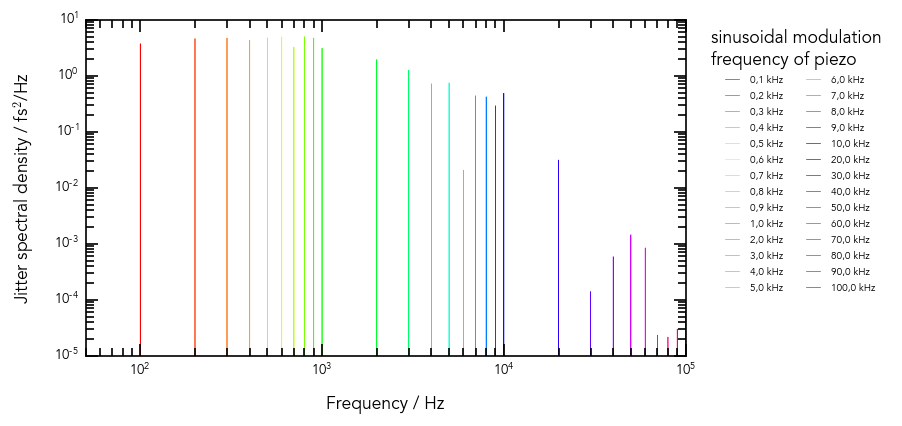

In [109]:
# Figure
from matplotlib import cm
# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

plt.style.use('ITWM')

N = 28
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.hsv(np.linspace(0,1,N)))

# Add two axes objects to create an inset figure
ax1 = fig.add_axes([0, 0, 1, 1])
#ax2 = fig.add_axes([0.64, 0.63, 0.33, 0.30])

ax1.plot(df_Jxx['freq'], df_Jxx['100 Hz filtered'], linewidth=0.4, label='0,1 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['200 Hz filtered'], linewidth=0.4, label='0,2 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['300 Hz filtered'], linewidth=0.4, label='0,3 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['400 Hz filtered'], linewidth=0.4, label='0,4 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['500 Hz filtered'], linewidth=0.4, label='0,5 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['600 Hz filtered'], linewidth=0.4, label='0,6 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['700 Hz filtered'], linewidth=0.4, label='0,7 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['800 Hz filtered'], linewidth=0.4, label='0,8 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['900 Hz filtered'], linewidth=0.4, label='0,9 kHz', zorder=-25)

ax1.plot(df_Jxx['freq'], df_Jxx['1 kHz filtered'], linewidth=0.4, label='1,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['2 kHz filtered'], linewidth=0.4, label='2,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['3 kHz filtered'], linewidth=0.4, label='3,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['4 kHz filtered'], linewidth=0.4, label='4,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['5 kHz filtered'], linewidth=0.4, label='5,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['6 kHz filtered'], linewidth=0.4, label='6,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['7 kHz filtered'], linewidth=0.4, label='7,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['8 kHz filtered'], linewidth=0.4, label='8,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['9 kHz filtered'], linewidth=0.4, label='9,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['10 kHz filtered'], linewidth=0.4, label='10,0 kHz', zorder=-25)

ax1.plot(df_Jxx['freq'], df_Jxx['20 kHz filtered'], linewidth=0.4, label='20,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['30 kHz filtered'], linewidth=0.4, label='30,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['40 kHz filtered'], linewidth=0.4, label='40,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['50 kHz filtered'], linewidth=0.4, label='50,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['60 kHz filtered'], linewidth=0.4, label='60,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['70 kHz filtered'], linewidth=0.4, label='70,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['80 kHz filtered'], linewidth=0.4, label='80,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['90 kHz filtered'], linewidth=0.4, label='90,0 kHz', zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['100 kHz filtered'], linewidth=0.4, label='100,0 kHz', zorder=-25)

#ax1.plot(f_den_200Hz, Jxx_den_200Hz_mean, linewidth=0.4, label='0,2 kHz', zorder=-24)
#ax1.plot(f_den_300Hz, Jxx_den_300Hz_mean, linewidth=0.4, label='0,3 kHz', zorder=-23)
#ax1.plot(f_den_400Hz, Jxx_den_400Hz_mean, linewidth=0.4, label='0,4 kHz', zorder=-22)
#ax1.plot(f_den_500Hz, Jxx_den_500Hz_mean, linewidth=0.4, label='0,5 kHz', zorder=-21)
#ax1.plot(f_den_600Hz, Jxx_den_600Hz_mean, linewidth=0.4, label='0,6 kHz', zorder=-20)
#ax1.plot(f_den_700Hz, Jxx_den_700Hz_mean, linewidth=0.4, label='0,7 kHz', zorder=-19)
#ax1.plot(f_den_800Hz, Jxx_den_800Hz_mean, linewidth=0.4, label='0,8 kHz', zorder=-18)
#ax1.plot(f_den_900Hz, Jxx_den_900Hz_mean, linewidth=0.4, label='0,9 kHz', zorder=-17)

#ax1.plot(f_den_1kHz, Jxx_den_1kHz_mean, linewidth=0.4, label='1,0 kHz', zorder=-16)
#ax1.plot(f_den_2kHz, Jxx_den_2kHz_mean, linewidth=0.4, label='2,0 kHz', zorder=-15)
#ax1.plot(f_den_3kHz, Jxx_den_3kHz_mean, linewidth=0.4, label='3,0 kHz', zorder=-14)
#ax1.plot(f_den_4kHz, Jxx_den_4kHz_mean, linewidth=0.4, label='4,0 kHz', zorder=-13)
#ax1.plot(f_den_5kHz, Jxx_den_5kHz_mean, linewidth=0.4, label='5,0 kHz', zorder=-12)
#ax1.plot(f_den_6kHz, Jxx_den_6kHz_mean, linewidth=0.4, label='6,0 kHz', zorder=-11)
#ax1.plot(f_den_7kHz, Jxx_den_7kHz_mean, linewidth=0.4, label='7,0 kHz', zorder=-10)
#ax1.plot(f_den_8kHz, Jxx_den_8kHz_mean, linewidth=0.4, label='8,0 kHz', zorder=-9)
#ax1.plot(f_den_9kHz, Jxx_den_9kHz_mean, linewidth=0.4, label='9,0 kHz', zorder=-8)

#ax1.plot(f_den_10kHz, Jxx_den_10kHz_mean, linewidth=0.4, label='10,0 kHz', zorder=-7)
#ax1.plot(f_den_20kHz, Jxx_den_20kHz_mean, linewidth=0.4, label='20,0 kHz', zorder=-6)
#ax1.plot(f_den_30kHz, Jxx_den_30kHz_mean, linewidth=0.4, label='30,0 kHz', zorder=-5)
#ax1.plot(f_den_40kHz, Jxx_den_40kHz_mean, linewidth=0.4, label='40,0 kHz', zorder=-4)
#ax1.plot(f_den_50kHz, Jxx_den_50kHz_mean, linewidth=0.4, label='50,0 kHz', zorder=-3)
#ax1.plot(f_den_60kHz, Jxx_den_60kHz_mean, linewidth=0.4, label='60,0 kHz', zorder=-2)
#ax1.plot(f_den_70kHz, Jxx_den_70kHz_mean, linewidth=0.4, label='70,0 kHz', zorder=-1)
#ax1.plot(f_den_80kHz, Jxx_den_80kHz_mean, linewidth=0.4, label='80,0 kHz', zorder=26)
#ax1.plot(f_den_90kHz, Jxx_den_90kHz_mean, linewidth=0.4, label='90,0 kHz', zorder=27)

#ax1.plot(f_den_100kHz, Jxx_den_100kHz_mean, linewidth=0.4, label='100,0 kHz', zorder=28)
#ax1.plot(f_den_200kHz, Jxx_den_200kHz_mean, linewidth=0.4, label='200,0 kHz', zorder=29)
#ax1.plot(f_den_300kHz, Jxx_den_300kHz_mean, linewidth=0.4, label='300,0 kHz', zorder=30)
#ax1.plot(f_den_400kHz, Jxx_den_400kHz_mean, linewidth=0.4, label='400,0 kHz', zorder=31)
#ax1.plot(f_den_500kHz, Jxx_den_500kHz_mean, linewidth=0.4, label='500,0 kHz', zorder=32)


#ax2.plot(dens_100[0][0], Jxx_den_100_mean, linewidth=0.4, label='0,1 kHz', zorder=8)
#ax2.plot(f_den_15, Jxx_den_15, linewidth=0.4, label='15 nm', zorder=5)
#ax2.plot(f_den_10, Jxx_den_10, linewidth=0.4, label='10 nm', zorder=6)
#ax2.plot(f_den_5, Jxx_den_5, linewidth=0.4, label='5 nm', zorder=7)

ax1.set_xlim([5e1,1e5])
ax1.set_ylim([1e-5,1e1])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Frequency / Hz', fontsize=10.5)
ax1.set_ylabel('Jitter spectral density / fs$^2$/Hz', fontsize=10.5)
#ax1.set_title("Jitter spectral density - 5nm - LaseLock")

#mat = np.random.random((1,2))
#plt.imshow(mat, origin="lower", cmap='hsv', interpolation='nearest')
#plt.colorbar()
plt.legend(bbox_to_anchor=(1.35, 1), title='sinusoidal modulation \nfrequency of piezo', title_fontsize=10.5, markerscale=10.0, fontsize=6.0, ncol=2)

#ax2.set_xlim([1e3,1e4])
#ax2.set_ylim([1e-1,5e1])
#ax2.set_xscale('log')
#ax2.set_yscale('log')

#plt.savefig('JSDPiezoModulation_density_01.pdf', format='pdf')
#plt.savefig('JSDPiezoModulation_density_01')

plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

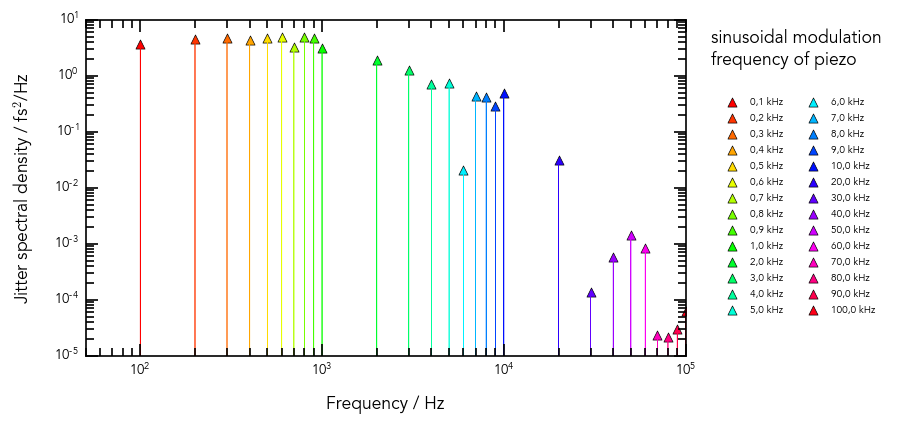

In [110]:
# Figure
from matplotlib import cm
# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

plt.style.use('ITWM')

N = 28
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.hsv(np.linspace(0,1,N)))

colors = plt.cm.hsv(np.linspace(0,1,N))
marker = '^'
size = 30

# Add two axes objects to create an inset figure
ax1 = fig.add_axes([0, 0, 1, 1])

ax1.plot(df_Jxx['freq'], df_Jxx['100 Hz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['200 Hz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['300 Hz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['400 Hz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['500 Hz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['600 Hz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['700 Hz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['800 Hz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['900 Hz filtered'], linewidth=0.4, zorder=-25)

ax1.plot(df_Jxx['freq'], df_Jxx['1 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['2 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['3 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['4 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['5 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['6 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['7 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['8 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['9 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['10 kHz filtered'], linewidth=0.4, zorder=-25)

ax1.plot(df_Jxx['freq'], df_Jxx['20 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['30 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['40 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['50 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['60 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['70 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['80 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['90 kHz filtered'], linewidth=0.4, zorder=-25)
ax1.plot(df_Jxx['freq'], df_Jxx['100 kHz filtered'], linewidth=0.4, zorder=-25)

ax1.scatter(df_Jxx['freq'], df_Jxx['100 Hz filtered'], linewidth=0.4, c=colors[0], marker=marker, s=size, label='0,1 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['200 Hz filtered'], linewidth=0.4, c=colors[1], marker=marker, s=size, label='0,2 kHz',  zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['300 Hz filtered'], linewidth=0.4, c=colors[2], marker=marker, s=size, label='0,3 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['400 Hz filtered'], linewidth=0.4, c=colors[3], marker=marker, s=size, label='0,4 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['500 Hz filtered'], linewidth=0.4, c=colors[4], marker=marker, s=size,  label='0,5 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['600 Hz filtered'], linewidth=0.4, c=colors[5], marker=marker, s=size,  label='0,6 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['700 Hz filtered'], linewidth=0.4, c=colors[6], marker=marker, s=size,  label='0,7 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['800 Hz filtered'], linewidth=0.4, c=colors[7], marker=marker, s=size,  label='0,8 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['900 Hz filtered'], linewidth=0.4, c=colors[8], marker=marker, s=size,  label='0,9 kHz', zorder=-25)

ax1.scatter(df_Jxx['freq'], df_Jxx['1 kHz filtered'], linewidth=0.4, c=colors[9], marker=marker, s=size,  label='1,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['2 kHz filtered'], linewidth=0.4, c=colors[10], marker=marker, s=size,  label='2,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['3 kHz filtered'], linewidth=0.4, c=colors[11], marker=marker, s=size,  label='3,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['4 kHz filtered'], linewidth=0.4, c=colors[12], marker=marker, s=size,  label='4,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['5 kHz filtered'], linewidth=0.4, c=colors[13], marker=marker, s=size,  label='5,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['6 kHz filtered'], linewidth=0.4, c=colors[14], marker=marker, s=size,  label='6,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['7 kHz filtered'], linewidth=0.4, c=colors[15], marker=marker, s=size,  label='7,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['8 kHz filtered'], linewidth=0.4, c=colors[16], marker=marker, s=size,  label='8,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['9 kHz filtered'], linewidth=0.4, c=colors[17], marker=marker, s=size,  label='9,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['10 kHz filtered'], linewidth=0.4, c=colors[18], marker=marker, s=size,  label='10,0 kHz', zorder=-25)

ax1.scatter(df_Jxx['freq'], df_Jxx['20 kHz filtered'], linewidth=0.4, c=colors[19], marker=marker, s=size,  label='20,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['30 kHz filtered'], linewidth=0.4, c=colors[20], marker=marker, s=size,  label='30,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['40 kHz filtered'], linewidth=0.4, c=colors[21], marker=marker, s=size,  label='40,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['50 kHz filtered'], linewidth=0.4, c=colors[22], marker=marker, s=size,  label='50,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['60 kHz filtered'], linewidth=0.4, c=colors[23], marker=marker, s=size,  label='60,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['70 kHz filtered'], linewidth=0.4, c=colors[24], marker=marker, s=size,  label='70,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['80 kHz filtered'], linewidth=0.4, c=colors[25], marker=marker, s=size,  label='80,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['90 kHz filtered'], linewidth=0.4, c=colors[26], marker=marker, s=size,  label='90,0 kHz', zorder=-25)
ax1.scatter(df_Jxx['freq'], df_Jxx['100 kHz filtered'], linewidth=0.4, c=colors[27], marker=marker, s=size,  label='100,0 kHz', zorder=-25)

ax1.set_xlim([5e1,1e5])
ax1.set_ylim([1e-5,1e1])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Frequency / Hz', fontsize=10.5)
ax1.set_ylabel('Jitter spectral density / fs$^2$/Hz', fontsize=10.5)
#ax1.set_title("Jitter spectral density - 5nm - LaseLock")

plt.legend(bbox_to_anchor=(1.35, 1), title='sinusoidal modulation \nfrequency of piezo\n', title_fontsize=10.5, markerscale=1.0, fontsize=6.0, scatterpoints=1, ncol=2)

plt.savefig('JSDPiezoModulation_density_linescatter_01.pdf', format='pdf')
plt.savefig('JSDPiezoModulation_density_linescatter_01')

plt.show()

### Wie viel Auslenkung kann minimal gemessen werden?

In [12]:
df_10=datawrangling('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,010Vamp_0,019Voff_300Hz_01.csv', 0.0)
df_10['jitter'] = df_10['voltage'].transform(lambda x: alpha_piezo_300*x)

df_65=datawrangling('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,065Vamp_0,245Voff_300Hz_01.csv', 0.0)
df_65['jitter'] = df_65['voltage'].transform(lambda x: alpha_piezo_300*x)

df_115=datawrangling('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,115Vamp_1,425Voff_300Hz_01.csv', 0.0)
df_115['jitter'] = df_115['voltage'].transform(lambda x: alpha_piezo_300*x)

df_365=datawrangling('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_0,365Vamp_1,955Voff_300Hz_01.csv', 0.0)
df_365['jitter'] = df_365['voltage'].transform(lambda x: alpha_piezo_300*x)

df_1000=datawrangling('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_1,0Vamp_1,76Voff_300Hz_01.csv', 0.0)
df_1000['jitter'] = df_1000['voltage'].transform(lambda x: alpha_piezo_300*x)

df_8000=datawrangling('/Users/felixjeskoparies/Desktop/JitterAnalysis/Piezo/DC_piezo_0,442dU_-0,10dx_8,0Vamp_10,2Voff_300Hz_01.csv', 0.0)
df_8000['jitter'] = df_8000['voltage'].transform(lambda x: alpha_piezo_300*x)

In [13]:
def fourierfiltering(df, bp_low, bp_high, timestep):
    # Fourier filtering of voltage signal, backtransformation, and calibration

    # FFT & filtering
    rf_fft = sp.fftpack.fft(df['voltage'])
    rf_psd = np.abs(rf_fft) ** 2
    rf_fftfreq = sp.fftpack.fftfreq(n=rf_psd.size, d=timestep)

    condition_rf_bandpass_low = np.abs(rf_fftfreq) <= bp_low 
    condition_rf_bandpass_high = np.abs(rf_fftfreq) >= bp_high

    rf_fft_filtered = rf_fft.copy()
    rf_fft_filtered[condition_rf_bandpass_low] = 0
    rf_fft_filtered[condition_rf_bandpass_high] = 0

    # Back transformation
    df['voltage_filtered'] = np.real(sp.fftpack.ifft(rf_fft_filtered))

    #Calibration
    df['jitter_filtered'] = df['voltage_filtered'].transform(lambda x: alpha_piezo_300*x)

In [14]:
fourierfiltering(df_10, 299, 301, timestep)
fourierfiltering(df_65, 299, 301, timestep)
fourierfiltering(df_115, 299, 301, timestep)
fourierfiltering(df_365, 299, 301, timestep)
fourierfiltering(df_1000, 299, 301, timestep)
fourierfiltering(df_8000, 299, 301, timestep)

In [229]:
# Fourier filtering of voltage signal, backtransformation, and calibration

# FFT & filtering
rf_fft = sp.fftpack.fft(df_65['voltage'])
rf_psd = np.abs(rf_fft) ** 2
rf_fftfreq = sp.fftpack.fftfreq(n=rf_psd.size, d=timestep)

condition_rf_bandpass_low = np.abs(rf_fftfreq) <= 299 
condition_rf_bandpass_high = np.abs(rf_fftfreq) >= 301

rf_fft_filtered = rf_fft.copy()
rf_fft_filtered[condition_rf_bandpass_low] = 0
rf_fft_filtered[condition_rf_bandpass_high] = 0

#rf_psd_filtered = np.abs(rf_fft_filtered) ** 2

# Back transformation
df_65['voltage_filtered'] = np.real(sp.fftpack.ifft(rf_fft_filtered))

#jit_fft = sp.fftpack.fft(df_red['jitter'])
#jit_psd = np.abs(jit_fft) ** 2
#jit_fftfreq = sp.fftpack.fftfreq(n=jit_psd.size, d=timestep)

#condition_jit_bandpass_low = np.abs(jit_fftfreq) <= 0
#condition_jit_bandpass_low[0]=False #Not filtering out offset
#condition_jit_bandpass_high = np.abs(jit_fftfreq) >= 1e6

#jit_fft_filtered = jit_fft.copy()
#jit_fft_filtered[condition_jit_bandpass_low] = 0
#jit_fft_filtered[condition_jit_bandpass_high] = 0

#jit_psd_filtered = np.abs(jit_fft_filtered) ** 2

#df_red['jitter_filtered'] = np.real(sp.fftpack.ifft(jit_fft_filtered))

#Calibration
df_65['jitter_filtered'] = df_65['voltage_filtered'].transform(lambda x: alpha_piezo_300*x)

Text(0, 0.5, 'Maximum of \ntemporal deviation / s')

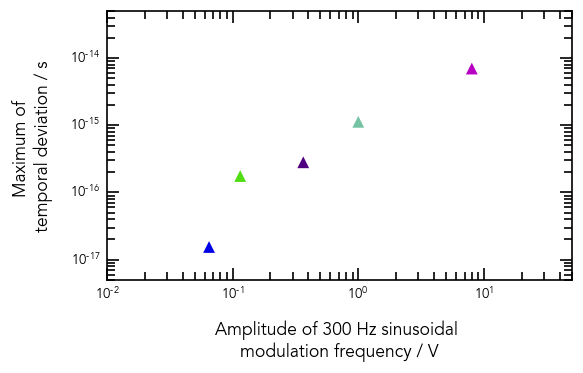

In [15]:
x = [0.065, 0.115, 0.365, 1.000, 8.000]
y = [df_65['jitter_filtered'].max(),
    df_115['jitter_filtered'].max(),
    df_365['jitter_filtered'].max(),
    df_1000['jitter_filtered'].max(),
    df_8000['jitter_filtered'].max()]

plt.scatter(x, y, c=colors[1:-1], marker='^', s=50, linewidth=0)
plt.style.use('ITWM')
plt.xlim(1e-2, 5e1)
plt.ylim(5e-18, 5e-14)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Amplitude of 300 Hz sinusoidal \nmodulation frequency / V", fontsize=10.5)
plt.ylabel("Maximum of \ntemporal deviation / s", fontsize=10.5)

#plt.savefig('Piezo_Modulation_MaxDeviation')
#plt.savefig('Piezo_Modulation_MaxDeviation.pdf', format='pdf')


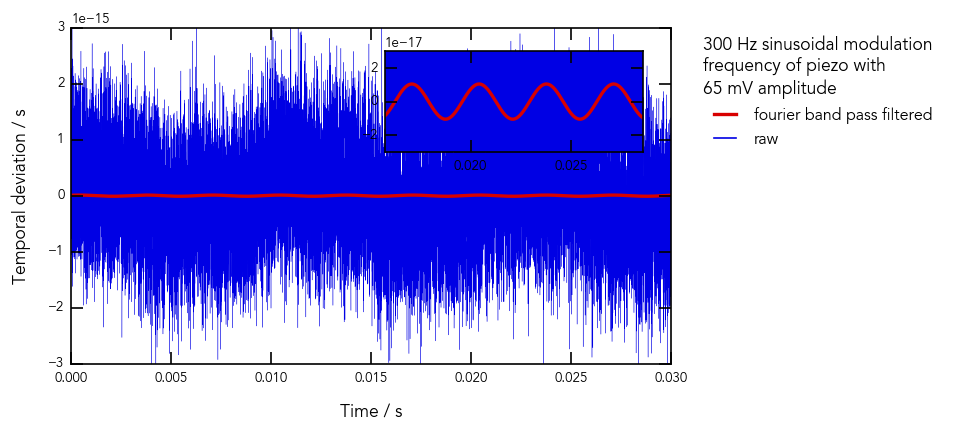

In [16]:
# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

plt.style.use('ITWM')

# Add two axes objects to create an inset figure
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0.5225, 0.63, 0.43, 0.30])

ax1.plot(df_65['time'], df_65['jitter_filtered'], linewidth=2.0, zorder=-1, label='fourier filtered')
ax1.plot(df_65['time'], df_65['jitter']-df_65['jitter'].mean(), linewidth=0.2, zorder=-2, label='raw')
ax1.set_xlim(0, 0.03)
ax1.set_ylim(-3.0*1e-15, 3.0*1e-15)
ax1.set_xlabel('Time / s', fontsize=10.5)
ax1.set_ylabel('Temporal deviation / s', fontsize=10.5)

ax2.plot(df_65['time'], df_65['jitter_filtered'], linewidth=2.0, zorder=2, label='fourier band pass filtered')
ax2.plot(df_65['time'], df_65['jitter']-df_65['jitter'].mean(), linewidth=1, zorder=1, label='raw')
ax2.set_xlim(0.01575, 0.02853)
ax2.set_ylim(-3.0*1e-17, 3.0*1e-17)
ax2.set_xticks([0.020, 0.025])
ax2.set_yticks([-2e-17, 0, 2e-17])
ax2.legend(bbox_to_anchor=(2.20,1.3), title='300 Hz sinusoidal modulation \nfrequency of piezo with \n65 mV amplitude', title_fontsize=10.5, markerscale=10.0)

#plt.savefig('TemporalDeviation_15attoseconds')
#plt.savefig('TemporalDeviation_15attoseconds.pdf', format='pdf')

0.17709066434261675


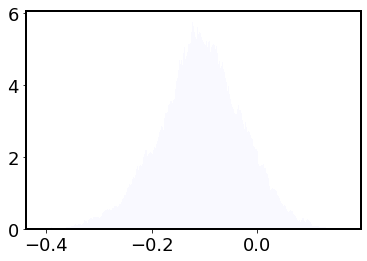

In [100]:
def GaussianFWHM(n, bins): 
    fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    
    #fit
    xdata    = bins[1:]
    ydata    = n
    init  = [1.0, 0.5, 0.5, 0.5]

    out   = leastsq(errfunc, init, args=(xdata, ydata))
    c = out[0]
    
    spline = UnivariateSpline(xdata, fitfunc(c, xdata)-np.max(fitfunc(c, xdata))/2, s=0)
    r1, r2 = spline.roots() # find the roots
    FWHM = abs(r2-r1)
    
    return(FWHM)

n, bins, patches = hist(df_voltage[paths[0]], 500, density=True, facecolor='blue', alpha = 0.025)
print(GaussianFWHM(n, bins))

In [9]:
# Path of .csv and percentage of reduction
path_15 = 'LaseLock/15nm/15nm_lase_0,10mm_03.csv'
path_10 = 'LaseLock/10nm/10nm_lase_0,04mm_09.csv'
path_5 = 'LaseLock/5nm/5nm_lase_0,10mm_05.csv'
path_0 = 'LaseLock/0nm/0nm_lase_0,10mm_08.csv'
#reduction = 0.00 # 0=no reduction 0.5=50% reduction #1=100% reduction

df_red_15 = datawrangling(path_15, 0.0)
df_red_10 = datawrangling(path_10, 0.0)
df_red_5 = datawrangling(path_5, 0.0)
df_red_0 = datawrangling(path_0, 0.0)

# Calibration constant alpha delta t / delta U
alpha_15 = 2.610*1e-12/1.47 # / s/V 
alpha_10 = 2.610*1e-12/1.65 # / s/V 
alpha_5 = 2.610*1e-12/1.36 # / s/V 
alpha_0 = 2.610*1e-12/1.22 # / s/V 

df_red_15['jitter'] = df_red_15['voltage'].transform(lambda x: alpha_15*x)
df_red_10['jitter'] = df_red_10['voltage'].transform(lambda x: alpha_10*x)
df_red_5['jitter'] = df_red_5['voltage'].transform(lambda x: alpha_5*x)
df_red_0['jitter'] = df_red_0['voltage'].transform(lambda x: alpha_0*x)

f_den_15, Jxx_den_15 = sp.signal.welch(df_red_15['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)
f_den_10, Jxx_den_10 = sp.signal.welch(df_red_10['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)
f_den_5, Jxx_den_5 = sp.signal.welch(df_red_5['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)
f_den_0, Jxx_den_0 = sp.signal.welch(df_red_0['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)


NameError: name 'fs' is not defined

In [93]:
# Path of .csv and percentage of reduction
path_1 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/ShortCircuit_25MSas_1mV.csv'
path_2 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/ShortCircuit_25MSas_2mV.csv'
path_3 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/ShortCircuit_25MSas_10mV.csv'
path_4 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/ShortCircuit_25MSas_20mV.csv'
path_5 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/ShortCircuit_25MSas_200mV.csv'
path_6 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/ShortCircuit_25MSas_500mV.csv'
path_7 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/ShortCircuit_25MSas_1000mV.csv'

#reduction = 0.00 # 0=no reduction 0.5=50% reduction #1=100% reduction

df_red_1 = datawrangling(path_1, 0.0)
df_red_2 = datawrangling(path_2, 0.0)
df_red_10 = datawrangling(path_3, 0.0)
df_red_20 = datawrangling(path_4, 0.0)
df_red_200 = datawrangling(path_5, 0.0)
df_red_500 = datawrangling(path_6, 0.0)
df_red_1000 = datawrangling(path_7, 0.0)
#df_red_5 = datawrangling(path_5, 0.0)
#df_red_0 = datawrangling(path_0, 0.0)

# Calibration constant alpha delta t / delta U
#alpha_15 = 2.610*1e-12/1.47 # / s/V 
#alpha_10 = 2.610*1e-12/1.65 # / s/V 
#alpha_5 = 2.610*1e-12/1.36 # / s/V 
#alpha_0 = 2.610*1e-12/1.22 # / s/V 

#df_red_15['jitter'] = df_red_15['voltage'].transform(lambda x: alpha_15*x)
#df_red_10['jitter'] = df_red_10['voltage'].transform(lambda x: alpha_10*x)
#df_red_5['jitter'] = df_red_5['voltage'].transform(lambda x: alpha_5*x)
#df_red_0['jitter'] = df_red_0['voltage'].transform(lambda x: alpha_0*x)

f_den_1000, Jxx_den_1000 = sp.signal.welch(df_red_1000['voltage'], bandwidth, scaling='density', nperseg=len(df_red_1000['voltage'])/5)
f_den_500, Jxx_den_500 = sp.signal.welch(df_red_500['voltage'], bandwidth, scaling='density', nperseg=len(df_red_500['voltage'])/5)
f_den_200, Jxx_den_200 = sp.signal.welch(df_red_200['voltage'], bandwidth, scaling='density', nperseg=len(df_red_200['voltage'])/5)
f_den_20, Jxx_den_20 = sp.signal.welch(df_red_20['voltage'], bandwidth, scaling='density', nperseg=len(df_red_20['voltage'])/5)
f_den_10, Jxx_den_10 = sp.signal.welch(df_red_10['voltage'], bandwidth, scaling='density', nperseg=len(df_red_10['voltage'])/5)
f_den_2, Jxx_den_2 = sp.signal.welch(df_red_2['voltage'], bandwidth, scaling='density', nperseg=len(df_red_2['voltage'])/5)
f_den_1, Jxx_den_1 = sp.signal.welch(df_red_1['voltage'], bandwidth, scaling='density', nperseg=len(df_red_1['voltage'])/5)

#f_den_10, Jxx_den_10 = sp.signal.welch(df_red_10['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)
#f_den_5, Jxx_den_5 = sp.signal.welch(df_red_5['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)
#f_den_0, Jxx_den_0 = sp.signal.welch(df_red_0['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)


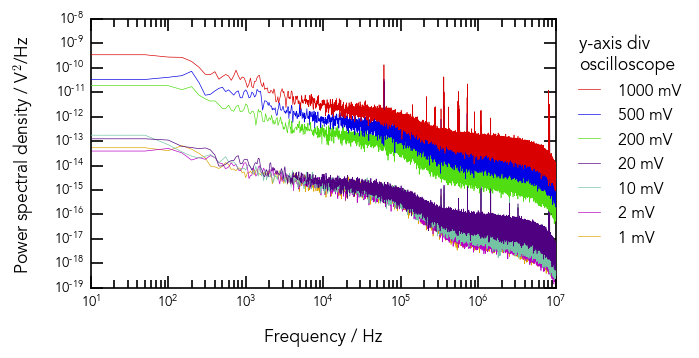

In [100]:
# Figure
fig, ax = plt.subplots(1,1)
plt.style.use("ITWM")

plt.plot(f_den_1000, Jxx_den_1000, linewidth=0.4, label='1000 mV', zorder=7)
plt.plot(f_den_500, Jxx_den_500, linewidth=0.4, label='500 mV', zorder=6) 
plt.plot(f_den_200, Jxx_den_200, linewidth=0.4, label='200 mV', zorder=5)
plt.plot(f_den_20, Jxx_den_20, linewidth=0.4, label='20 mV', zorder=4)
plt.plot(f_den_10, Jxx_den_10, linewidth=0.4, label='10 mV', zorder=3)
plt.plot(f_den_2, Jxx_den_2, linewidth=0.4, label='2 mV', zorder=2)
plt.plot(f_den_1, Jxx_den_1, linewidth=0.4, label='1 mV', zorder=1)

plt.xlim([1e1,1e7])
plt.ylim([1e-19,1e-8])
#plt.size(5,10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency / Hz', fontsize=10.5)
plt.ylabel('Power spectral density / V$^2$/Hz', fontsize=10.5)
#plt.title("Power spectral density - Short circuit oscilloscope", fontsize=10.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.30, 1.00), title='y-axis div \noscilloscope', title_fontsize=10.5, markerscale=10.0)

plt.savefig('ShortCircuit.png')
plt.show()

In [65]:
# Path of .csv and percentage of reduction
path_1_50_50 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/50-50/0nm_50-50_0,00mm_1,00V_03.csv'
path_2_50_50 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/50-50/0nm_50-50_0,00mm_0,50V_03.csv'
path_3_50_50 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/50-50/0nm_50-50_0,00mm_0,20V_03.csv'
path_4_50_50 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/50-50/0nm_50-50_0,00mm_0,02V_03.csv'
path_5_50_50 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/50-50/0nm_50-50_0,00mm_0,01V_03.csv'
path_6_50_50 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/50-50/0nm_50-50_0,00mm_0,002V_03.csv'
path_7_50_50 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/50-50/0nm_50-50_0,00mm_0,001V_03.csv'
path_8_50_50 = '/Users/felixjeskoparies/Desktop/JitterAnalysis/50-50/0nm_50-50_0,00mm_0Vavg_05.csv'

#reduction = 0.00 # 0=no reduction 0.5=50% reduction #1=100% reduction

df_red_1_50_50 = datawrangling(path_1_50_50, 0.0)
df_red_2_50_50 = datawrangling(path_2_50_50, 0.0)
df_red_10_50_50 = datawrangling(path_3_50_50, 0.0)
df_red_20_50_50 = datawrangling(path_4_50_50, 0.0)
df_red_200_50_50 = datawrangling(path_5_50_50, 0.0)
df_red_500_50_50 = datawrangling(path_6_50_50, 0.0)
df_red_1000_50_50 = datawrangling(path_7_50_50, 0.0)

df_red_0_50_50 = datawrangling(path_8_50_50, 0.0)
#df_red_5 = datawrangling(path_5, 0.0)
#df_red_0 = datawrangling(path_0, 0.0)

# Calibration constant alpha delta t / delta U
#alpha_15 = 2.610*1e-12/1.47 # / s/V 
#alpha_10 = 2.610*1e-12/1.65 # / s/V 
#alpha_5 = 2.610*1e-12/1.36 # / s/V 
#alpha_0 = 2.610*1e-12/1.22 # / s/V 

#df_red_15['jitter'] = df_red_15['voltage'].transform(lambda x: alpha_15*x)
#df_red_10['jitter'] = df_red_10['voltage'].transform(lambda x: alpha_10*x)
#df_red_5['jitter'] = df_red_5['voltage'].transform(lambda x: alpha_5*x)
#df_red_0['jitter'] = df_red_0['voltage'].transform(lambda x: alpha_0*x)

f_den_1000_50_50, Jxx_den_1000_50_50 = sp.signal.welch(df_red_1000_50_50['voltage'], bandwidth, scaling='density', nperseg=len(df_red_1000_50_50['voltage'])/5)
f_den_500_50_50, Jxx_den_500_50_50 = sp.signal.welch(df_red_500_50_50['voltage'], bandwidth, scaling='density', nperseg=len(df_red_500_50_50['voltage'])/5)
f_den_200_50_50, Jxx_den_200_50_50 = sp.signal.welch(df_red_200_50_50['voltage'], bandwidth, scaling='density', nperseg=len(df_red_200_50_50['voltage'])/5)
f_den_20_50_50, Jxx_den_20_50_50 = sp.signal.welch(df_red_20_50_50['voltage'], bandwidth, scaling='density', nperseg=len(df_red_20_50_50['voltage'])/5)
f_den_10_50_50, Jxx_den_10_50_50 = sp.signal.welch(df_red_10_50_50['voltage'], bandwidth, scaling='density', nperseg=len(df_red_10_50_50['voltage'])/5)
f_den_2_50_50, Jxx_den_2_50_50 = sp.signal.welch(df_red_2_50_50['voltage'], bandwidth, scaling='density', nperseg=len(df_red_2_50_50['voltage'])/5)
f_den_1_50_50, Jxx_den_1_50_50 = sp.signal.welch(df_red_1_50_50['voltage'], bandwidth, scaling='density', nperseg=len(df_red_1_50_50['voltage'])/5)

f_den_0_50_50, Jxx_den_0_50_50 = sp.signal.welch(df_red_0_50_50['voltage'], bandwidth, scaling='density', nperseg=len(df_red_0_50_50['voltage'])/5)

#f_den_10, Jxx_den_10 = sp.signal.welch(df_red_10['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)
#f_den_5, Jxx_den_5 = sp.signal.welch(df_red_5['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)
#f_den_0, Jxx_den_0 = sp.signal.welch(df_red_0['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg/5)


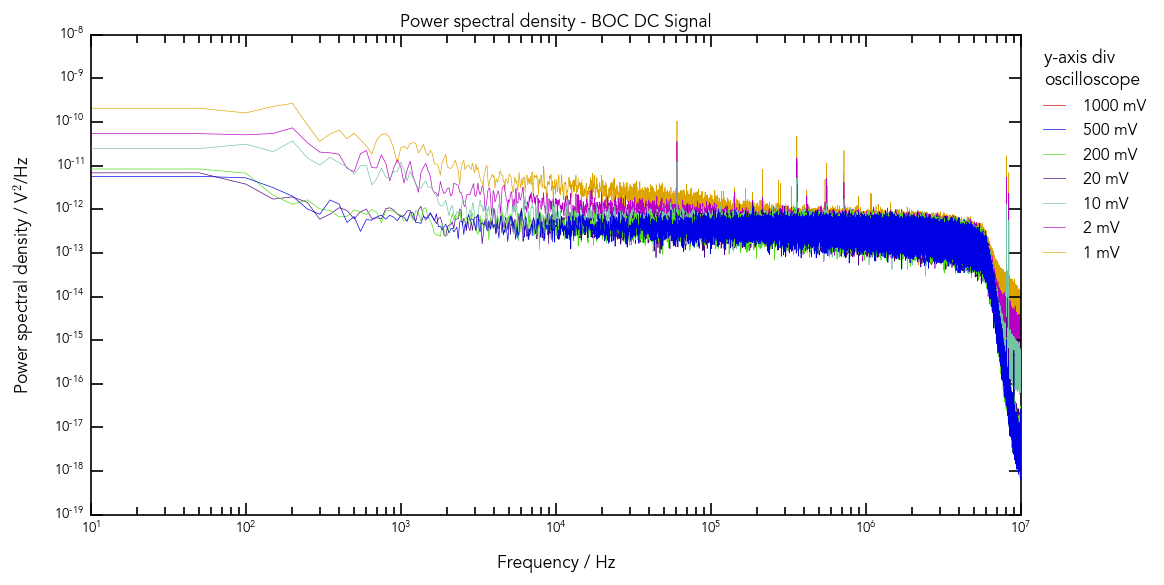

In [87]:
# Figure
fig, ax = plt.subplots(1,1, figsize = (10,5))
plt.style.use("ITWM")

plt.plot(f_den_1000_50_50, Jxx_den_1000_50_50, linewidth=0.4, label='1000 mV', zorder=7)
plt.plot(f_den_500_50_50, Jxx_den_500_50_50, linewidth=0.4, label='500 mV', zorder=6) 
plt.plot(f_den_200_50_50, Jxx_den_200_50_50, linewidth=0.4, label='200 mV', zorder=5)
plt.plot(f_den_20_50_50, Jxx_den_20_50_50, linewidth=0.4, label='20 mV', zorder=4)
plt.plot(f_den_10_50_50, Jxx_den_10_50_50, linewidth=0.4, label='10 mV', zorder=3)
plt.plot(f_den_2_50_50, Jxx_den_2_50_50, linewidth=0.4, label='2 mV', zorder=2)
plt.plot(f_den_1_50_50, Jxx_den_1_50_50, linewidth=0.4, label='1 mV', zorder=1)

plt.xlim([1e1,1e7])
plt.ylim([1e-19,1e-8])
#plt.size(5,10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency / Hz', fontsize=10.5)
plt.ylabel('Power spectral density / V$^2$/Hz', fontsize=10.5)
plt.title("Power spectral density - BOC DC Signal", fontsize=10.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.00), title='y-axis div \noscilloscope', title_fontsize=10.5, markerscale=10.0)

plt.savefig('50-50')
plt.show()

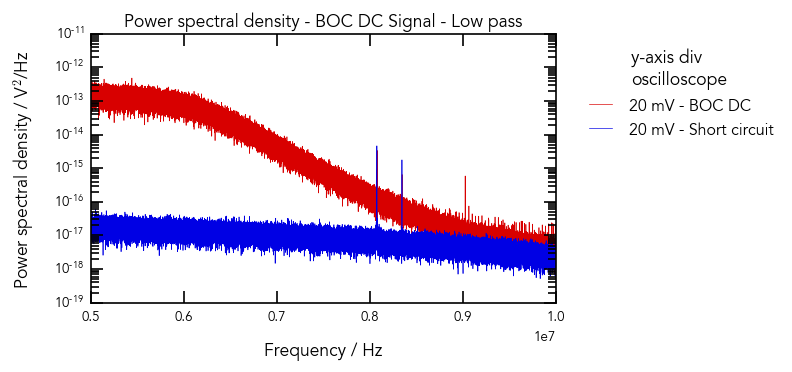

In [97]:
# Figure
fig, ax = plt.subplots(1,1)
plt.style.use("ITWM")

plt.plot(f_den_20_50_50, Jxx_den_20_50_50, linewidth=0.4, label='20 mV - BOC DC')
plt.plot(f_den_20, Jxx_den_20, linewidth=0.4, label='20 mV - Short circuit')


plt.xlim([5e6,1e7])
plt.ylim([1e-19,1e-11])
#plt.size(5,10)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency / Hz', fontsize=10.5)
plt.ylabel('Power spectral density / V$^2$/Hz', fontsize=10.5)
plt.title("Power spectral density - BOC DC Signal - Low pass", fontsize=10.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.50, 1.00), title='y-axis div \noscilloscope', title_fontsize=10.5, markerscale=10.0)

plt.savefig('BOCDC_vs_ShortCircuit_zoom')
plt.show()

In [24]:
# Path of .csv and percentage of reduction
path_BPDon = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/NEW/Oscilloscope/BPD_on_nolight_25MSas_20mV_03.csv' #no light
path_BPDoff = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/NEW/Oscilloscope/BPD_off_nolight_noLP_25MSas_20mV_02.csv' #no light
path_BPDon_lp = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/NEW/Oscilloscope/BPD_on_nolight_2,5MHzLP_25MSas_20mV_02.csv' #no light
path_BPDoff_lp = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/NEW/Oscilloscope/BPD_off_nolight_2,5MHzLP_25MSas_20mV_02.csv' #no light

path_BPDon_DC0mV = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/NEW/Oscilloscope/BPD_on_DC0V_noLP_25MSas_20mV.csv' #DC 0mV
path_BPDon_DC0mV_lp = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/NEW/Oscilloscope/BPD_on_DC0V_2,5MHzLP_25MSas_20mV.csv' #DC 0mV
path_BPDon_DC35mV = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/NEW/Oscilloscope/BPD_on_DC35mV_noLP_25MSas_20mV.csv' #DC 35mV
path_BPDon_DC60mV_lp = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/NEW/Oscilloscope/BPD_on_DC60mV_2,5MHzLP_25MSas_20mV.csv' #DC 60mV

path_short_circuit = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/ShortCircuit_25MSas_20mV.csv'

df_red_BPDon = datawrangling(path_BPDon, 0.0)
df_red_BPDoff = datawrangling(path_BPDoff, 0.0)
df_red_BPDon_lp = datawrangling(path_BPDon_lp, 0.0)
df_red_BPDoff_lp = datawrangling(path_BPDoff_lp, 0.0)
df_red_short_circuit = datawrangling(path_short_circuit, 0.0)

df_red_BPDon_DC0mV = datawrangling(path_BPDon_DC0mV, 0.0)
df_red_BPDon_DC0mV_lp = datawrangling(path_BPDon_DC0mV_lp, 0.0)
df_red_BPDon_DC35mV = datawrangling(path_BPDon_DC35mV, 0.0)
df_red_BPDon_DC60mV_lp = datawrangling(path_BPDon_DC60mV_lp, 0.0)

f_den_BPDon, Jxx_den_BPDon = sp.signal.welch(df_red_BPDon['voltage'], bandwidth, scaling='density', nperseg=len(df_red_BPDon['voltage'])/5)
f_den_BPDoff, Jxx_den_BPDoff = sp.signal.welch(df_red_BPDoff['voltage'], bandwidth, scaling='density', nperseg=len(df_red_BPDoff['voltage'])/5)
f_den_BPDon_lp, Jxx_den_BPDon_lp = sp.signal.welch(df_red_BPDon_lp['voltage'], bandwidth, scaling='density', nperseg=len(df_red_BPDon_lp['voltage'])/5)
f_den_BPDoff_lp, Jxx_den_BPDoff_lp = sp.signal.welch(df_red_BPDoff_lp['voltage'], bandwidth, scaling='density', nperseg=len(df_red_BPDoff_lp['voltage'])/5)

f_den_BPDon_DC0mV, Jxx_den_BPDon_DC0mV = sp.signal.welch(df_red_BPDon_DC0mV['voltage'], bandwidth, scaling='density', nperseg=len(df_red_BPDon_DC0mV['voltage'])/5)
f_den_BPDon_DC0mV_lp, Jxx_den_BPDon_DC0mV_lp = sp.signal.welch(df_red_BPDon_DC0mV_lp['voltage'], bandwidth, scaling='density', nperseg=len(df_red_BPDon_DC0mV_lp['voltage'])/5)
f_den_BPDon_DC35mV, Jxx_den_BPDon_DC35mV = sp.signal.welch(df_red_BPDon_DC35mV['voltage'], bandwidth, scaling='density', nperseg=len(df_red_BPDon_DC35mV['voltage'])/5)
f_den_BPDon_DC60mV_lp, Jxx_den_BPDon_DC60mV_lp = sp.signal.welch(df_red_BPDon_DC60mV_lp['voltage'], bandwidth, scaling='density', nperseg=len(df_red_BPDon_DC60mV_lp['voltage'])/5)

f_den_short_circuit, Jxx_den_short_circuit = sp.signal.welch(df_red_short_circuit['voltage'], bandwidth, scaling='density', nperseg=len(df_red_short_circuit['voltage'])/5)

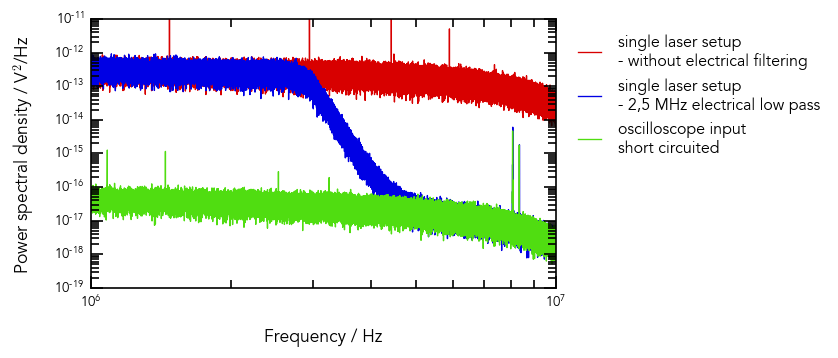

In [48]:
# Figure
fig, ax = plt.subplots(1,1)
plt.style.use("ITWM")

#plt.plot(f_den_BPDon, Jxx_den_BPDon, linewidth=0.4, label='20 mV (div) - BPD on - no light', zorder=10)
#plt.plot(f_den_BPDoff, Jxx_den_BPDoff, linewidth=0.4, label='20 mV (div) - BPD off - no light', zorder=9)
#plt.plot(f_den_BPDon_lp, Jxx_den_BPDon_lp, linewidth=0.4, label='20 mV (div) - BPD on - no light - 2,5 MHz low pass')
#plt.plot(f_den_BPDoff_lp, Jxx_den_BPDoff_lp, linewidth=0.4, label='20 mV (div) - BPD off - no light - 2,5 MHz low pass')

plt.plot(f_den_BPDon_DC0mV, Jxx_den_BPDon_DC0mV, linewidth=0.8, label='single laser setup \n- without electrical filtering')
plt.plot(f_den_BPDon_DC0mV_lp, Jxx_den_BPDon_DC0mV_lp, linewidth=0.8, label='single laser setup \n- 2,5 MHz electrical low pass')
#plt.plot(f_den_BPDon_DC35mV, Jxx_den_BPDon_DC35mV, linewidth=0.4, label='20 mV (div) - BOC DC 35mV')
#plt.plot(f_den_BPDon_DC60mV_lp, Jxx_den_BPDon_DC60mV_lp, linewidth=0.4, label='20 mV (div) - BOC DC 60mV - 2,5 MHz low pass')

#plt.plot(f_den_20_50_50, Jxx_den_20_50_50, linewidth=0.4, label='20 mV (div) - BOC DC (50:50) - 5,0 MHz low pass')
#plt.plot(f_den_20, Jxx_den_20, linewidth=0.4, label='20 mV (div) - Short circuit')
plt.plot(f_den_short_circuit, Jxx_den_short_circuit, linewidth=0.8, label='oscilloscope input \nshort circuited')


plt.xlim([1e6,1e7])
plt.ylim([1e-19,1e-11])
#plt.size(5,10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency / Hz', fontsize=10.5)
plt.ylabel('Power spectral density / V$^2$/Hz', fontsize=10.5)
#plt.title("Power spectral density ", fontsize=10.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.60, 1.00), title_fontsize=10.5, markerscale=10.0)

plt.savefig('Photodiode_Noise_new_DC_comparison_zoom')
plt.savefig('Photodiode_Noise_new_DC_comparison_zoom.pdf', format='pdf')
plt.show()

In [7]:
# Path of .csv and percentage of reduction
path_500kHz = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/BPD_on_pump_40mA_500kHz_4,7V_25MSas_20mV.csv' #no light
path_550kHz = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/BPD_on_pump_40mA_550kHz_4,7V_25MSas_20mV.csv' #no light
path_600kHz = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShotNoise/BPD_on_pump_40mA_600kHz_4,7V_25MSas_20mV.csv' #no light

path_short_circuit = '/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/ShortCircuit_25MSas_20mV.csv'

df_red_500kHz = datawrangling(path_500kHz, 0.0)
df_red_550kHz = datawrangling(path_550kHz, 0.0)
df_red_600kHz = datawrangling(path_600kHz, 0.0)

df_red_short_circuit = datawrangling(path_short_circuit, 0.0)

f_den_500kHz, Jxx_den_500kHz = sp.signal.welch(df_red_500kHz['voltage'], bandwidth, scaling='density', nperseg=len(df_red_500kHz['voltage'])/5)
f_den_550kHz, Jxx_den_550kHz = sp.signal.welch(df_red_550kHz['voltage'], bandwidth, scaling='density', nperseg=len(df_red_550kHz['voltage'])/5)
f_den_600kHz, Jxx_den_600kHz = sp.signal.welch(df_red_600kHz['voltage'], bandwidth, scaling='density', nperseg=len(df_red_600kHz['voltage'])/5)

f_den_short_circuit, Jxx_den_short_circuit = sp.signal.welch(df_red_short_circuit['voltage'], bandwidth, scaling='density', nperseg=len(df_red_short_circuit['voltage'])/5)

In [49]:
df_csv = pd.DataFrame({'f_den_short': f_den_short_circuit, 
                    'Jxx_den_short': Jxx_den_short_circuit,
                    'f_den_500kHz': f_den_500kHz,
                    'Jxx_den_500kHz': Jxx_den_500kHz,
                    'f_den_550kHz': f_den_550kHz,
                    'Jxx_den_550kHz': Jxx_den_550kHz,
                    'f_den_600kHz': f_den_600kHz,
                    'Jxx_den_600kHz': Jxx_den_600kHz})

df_csv.to_csv(r'/Users/felixjeskoparies/Desktop/JitterAnalysis/ShortCircuit/f_Jxx_den.csv')

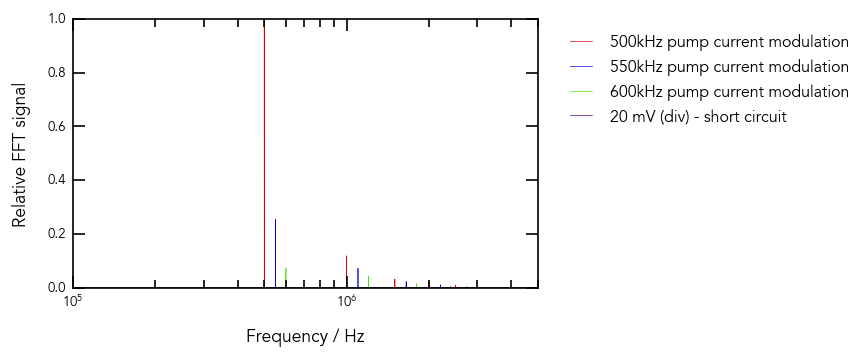

In [53]:
# Figure
fig, ax = plt.subplots(1,1)
plt.style.use("ITWM")

plt.plot(f_den_500kHz, Jxx_den_500kHz/(Jxx_den_500kHz.max()), linewidth=0.4, label='500kHz pump current modulation')
plt.plot(f_den_550kHz, Jxx_den_550kHz/(Jxx_den_500kHz.max()), linewidth=0.4, label='550kHz pump current modulation')
plt.plot(f_den_600kHz, Jxx_den_600kHz/(Jxx_den_500kHz.max()), linewidth=0.4, label='600kHz pump current modulation')
#plt.plot(f_den_20_50_50, Jxx_den_20_50_50, linewidth=0.4, label='20 mV (div) - BOC DC (50:50) - 5,0 MHz low pass')
#plt.plot(f_den_20, Jxx_den_20, linewidth=0.4, label='20 mV (div) - Short circuit')
plt.plot(f_den_short_circuit, Jxx_den_short_circuit/(Jxx_den_500kHz.max()), linewidth=0.4, label='20 mV (div) - short circuit')


plt.xlim([1e5,5e6])
plt.ylim([0,1])
#plt.size(5,10)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Frequency / Hz', fontsize=10.5)
plt.ylabel('Relative FFT signal', fontsize=10.5)
#plt.title("Power spectral density ", fontsize=10.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.70, 1.00), title_fontsize=10.5, markerscale=10.0)

plt.savefig('pump_current_modulation_osci_relative_01.pdf', format='pdf')
plt.savefig('pump_current_modulation_osci_relative_01.png', format='png')
plt.show()

### Run  (Histograms)

In [20]:
paths_i = ['0nm/0nm_lase_0,10mm_07.csv']

In [21]:
reduction = 0.9 # percentage of reduction
list_df = []

for i in paths_i:
    list_df.append(datawrangling(i, reduction)['voltage'])
    #list_df.append(datawrangling(i)['voltage'])
    
df_hist = pd.DataFrame(list_df).T


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
# the histogram of the data
fig, ax = plt.subplots(1,5, figsize=(27,9))
ax[0].hist(df_hist.iloc[:, 0], 100, density=True, facecolor='m', alpha=1.0)
ax[0].set_title('15 nm')
ax[1].hist(df_hist.iloc[:, 1], 100, density=True, facecolor='r', alpha=1.0)
ax[1].set_title('10 nm')
ax[2].hist(df_hist.iloc[:, 2], 100, density=True, facecolor='b', alpha=1.0)
ax[2].set_title('5 nm')
ax[3].hist(df_hist.iloc[:, 3], 100, density=True, facecolor='g', alpha=1.0)
ax[3].set_title('without band pass')
#ax[4].hist(df_hist.iloc[:, 4], 100, density=True, facecolor='y', alpha=1.0)
#ax[4].set_title('p25, i3000')

#set same x,y limits for all subplots
for i, subplot in np.ndenumerate(ax):
    subplot.set_xlim(-0.5, 0.5)
    subplot.set_ylim(0,15)
    subplot.set_xlabel('Voltage / V')
    subplot.set_ylabel('Counts')

plt.show()

In [124]:
paths_p = ['SlapLock/10nm/10nm_slap_0,04mm_i3000_p5_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p10_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p15_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p20_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p25_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p30_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p35_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p40_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p45_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p50_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p60_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p70_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p80_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p90_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_i3000_p100_01.csv'        
        ]

paths_i = ['SlapLock/10nm/10nm_slap_0,04mm_p25_i50_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i100_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i150_01.csv',
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i200_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i250_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i300_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i350_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i400_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i450_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i500_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i750_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i1000_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i2000_01.csv', 
           'SlapLock/10nm/10nm_slap_0,04mm_p25_i3000_01.csv' 
        ]

In [33]:
## list_df = []
df_hist_p_01 = pd.DataFrame()
df_hist_p_02 = pd.DataFrame()
df_hist_p_03 = pd.DataFrame()

for i in paths_p:
    df_hist_p_01[i[31:-7]] = datawrangling(i[:-6]+'01.csv')['voltage']
    df_hist_p_02[i[31:-7]] = datawrangling(i[:-6]+'02.csv')['voltage']
    df_hist_p_03[i[31:-7]] = datawrangling(i[:-6]+'03.csv')['voltage']
    #list_df.append(datawrangling(i)['voltage']

In [125]:
## list_df = []
df_hist_i_01 = pd.DataFrame()
df_hist_i_02 = pd.DataFrame()
df_hist_i_03 = pd.DataFrame()

for i in paths_i:
    df_hist_i_01[i[31:-7]] = datawrangling(i[:-6]+'01.csv')['voltage']
    df_hist_i_02[i[31:-7]] = datawrangling(i[:-6]+'02.csv')['voltage']
    df_hist_i_03[i[31:-7]] = datawrangling(i[:-6]+'03.csv')['voltage']
    #list_df.append(datawrangling(i)['voltage']

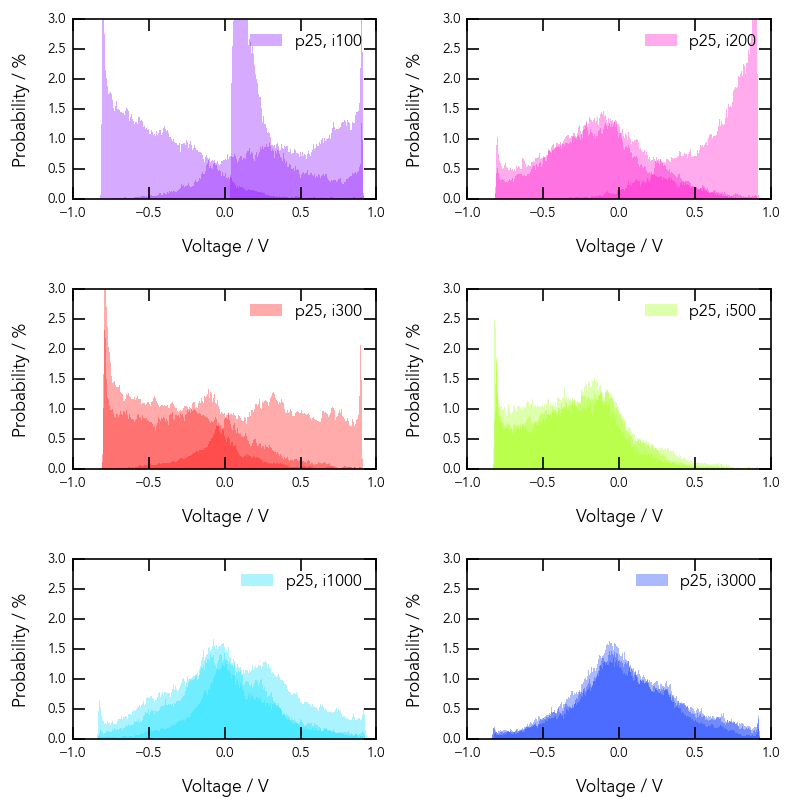

In [129]:
# the histogram of the data

fig, ax = plt.subplots(3,2, figsize=(7.5,7.5))
plt.style.use('ITWM')
plt.subplots_adjust(hspace=0.5, wspace=0.3)

N = 18
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.hsv(np.linspace(0,1,N)))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

ax[0,0].hist(df_hist_i_01['p25_i100'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-5], label='p25, i100')
ax[0,0].hist(df_hist_i_02['p25_i100'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-5])
ax[0,0].hist(df_hist_i_03['p25_i100'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-5])
#ax[0,0].set_title('p5, i3000')

ax[0,1].hist(df_hist_i_01['p25_i200'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-3], label='p25, i200')
ax[0,1].hist(df_hist_i_02['p25_i200'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-3])
ax[0,1].hist(df_hist_i_03['p25_i200'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-3])
#ax[0,1].set_title('p10, i1000')

ax[1,0].hist(df_hist_i_01['p25_i300'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[0], label='p25, i300')
ax[1,0].hist(df_hist_i_02['p25_i300'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[0])
ax[1,0].hist(df_hist_i_03['p25_i300'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[0])
#ax[0,2].set_title('p20, i1000')

ax[1,1].hist(df_hist_i_01['p25_i500'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[4], label='p25, i500')
ax[1,1].hist(df_hist_i_02['p25_i500'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[4])
ax[1,1].hist(df_hist_i_03['p25_i500'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[4])
#ax[1,0].set_title('p40, i1000')

ax[2,0].hist(df_hist_i_01['p25_i1000'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[9], label='p25, i1000')
ax[2,0].hist(df_hist_i_02['p25_i1000'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[9])
ax[2,0].hist(df_hist_i_03['p25_i1000'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[9])
#ax[1,1].set_title('p80, i1000')

ax[2,1].hist(df_hist_i_01['p25_i3000'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[11], label='p25, i3000')
ax[2,1].hist(df_hist_i_02['p25_i3000'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[11])
ax[2,1].hist(df_hist_i_03['p25_i3000'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[11])
#ax[1,2].set_title('p100, i1000')

#set same x,y limits for all subplots
for i, subplot in np.ndenumerate(ax):
    subplot.set_xlim(-1, 1)
    subplot.set_ylim(0,3)
    subplot.set_xlabel('Voltage / V', fontsize=10.5)
    subplot.set_ylabel('Probability / %', fontsize=10.5)
    subplot.legend()

plt.savefig("Histograms_constantP")
plt.savefig("Histograms_constantP.pdf", format='pdf')

plt.show()
    
#df_hist_p = pd.DataFrame(list_df).T

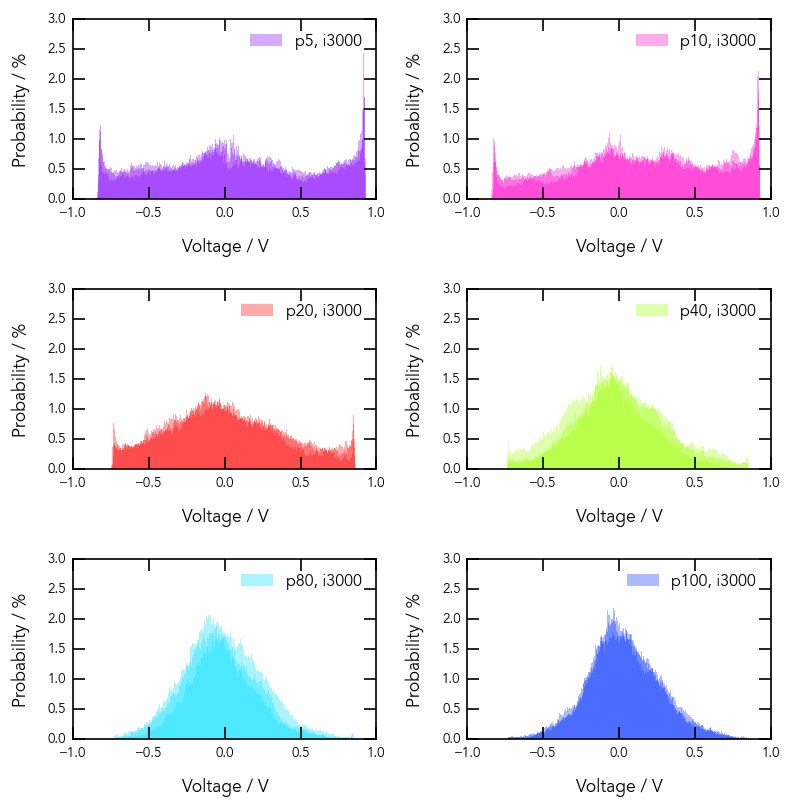

In [67]:
# the histogram of the data

fig, ax = plt.subplots(3,2, figsize=(7.5,7.5))
plt.style.use('ITWM')
plt.subplots_adjust(hspace=0.5, wspace=0.3)

N = 18
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.hsv(np.linspace(0,1,N)))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

ax[0,0].hist(df_hist_p_01['i3000_p5'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-5], label='p5, i3000')
ax[0,0].hist(df_hist_p_02['i3000_p5'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-5])
ax[0,0].hist(df_hist_p_03['i3000_p5'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-5])
#ax[0,0].set_title('p5, i3000')

ax[0,1].hist(df_hist_p_01['i3000_p10'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-3], label='p10, i3000')
ax[0,1].hist(df_hist_p_02['i3000_p10'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-3])
ax[0,1].hist(df_hist_p_03['i3000_p10'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[-3])
#ax[0,1].set_title('p10, i1000')

ax[1,0].hist(df_hist_p_01['i3000_p20'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[0], label='p20, i3000')
ax[1,0].hist(df_hist_p_02['i3000_p20'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[0])
ax[1,0].hist(df_hist_p_03['i3000_p20'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[0])
#ax[0,2].set_title('p20, i1000')

ax[1,1].hist(df_hist_p_01['i3000_p40'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[4], label='p40, i3000')
ax[1,1].hist(df_hist_p_02['i3000_p40'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[4])
ax[1,1].hist(df_hist_p_03['i3000_p40'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[4])
#ax[1,0].set_title('p40, i1000')

ax[2,0].hist(df_hist_p_01['i3000_p80'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[9], label='p80, i3000')
ax[2,0].hist(df_hist_p_02['i3000_p80'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[9])
ax[2,0].hist(df_hist_p_03['i3000_p80'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[9])
#ax[1,1].set_title('p80, i1000')

ax[2,1].hist(df_hist_p_01['i3000_p100'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[11], label='p100, i3000')
ax[2,1].hist(df_hist_p_02['i3000_p100'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[11])
ax[2,1].hist(df_hist_p_03['i3000_p100'], 500, density=True, alpha=0.33, linewidth=0, facecolor=colors[11])
#ax[1,2].set_title('p100, i1000')

#set same x,y limits for all subplots
for i, subplot in np.ndenumerate(ax):
    subplot.set_xlim(-1, 1)
    subplot.set_ylim(0,3)
    subplot.set_xlabel('Voltage / V', fontsize=10.5)
    subplot.set_ylabel('Probability / %', fontsize=10.5)
    subplot.legend()

plt.savefig("Histograms_constantI")
plt.savefig("Histograms_constantI.pdf", format='pdf')

plt.show()
    
#df_hist_p = pd.DataFrame(list_df).T

In [139]:
# SlapLock - PID Histograms

paths_i_3 = ['SlapLock/10nm/10nm_slap_0,04mm_i3000_p5_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p10_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p15_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p20_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p25_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p30_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p35_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p40_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p45_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p50_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p60_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p70_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p80_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p90_03.csv',
             'SlapLock/10nm/10nm_slap_0,04mm_i3000_p100_03.csv'
            ]

df_voltage_pid_3 = pd.DataFrame()

for i in paths_i_3:
    #j = 0
    df_red = datawrangling(i)
    df_voltage_pid_3[i] = df_red['voltage']
    
    #calibration(alpha)
    
    #fs = bandwidth
    #nperseg= len(df_red['jitter'])
    #f_den, Jxx_den = sp.signal.welch(df_red['jitter'].transform(lambda x: x*1e15), fs, scaling='density', nperseg=nperseg)
        
    #f_spectra[i] = Jxx_den
    
#df_voltage['mean'] = df_voltage.mean(axis=1)
#df_spectra['mean'] = df_spectra.mean(axis=1)
#df_spectra['0'] = f_den

In [ ]:
for i in [1,2,3]:

In [ ]:
n, bins, patches = hist(df_voltage[paths[0]], 500, density=True, facecolor='blue', alpha = 0.025)
print(GaussianFWHM(n, bins))

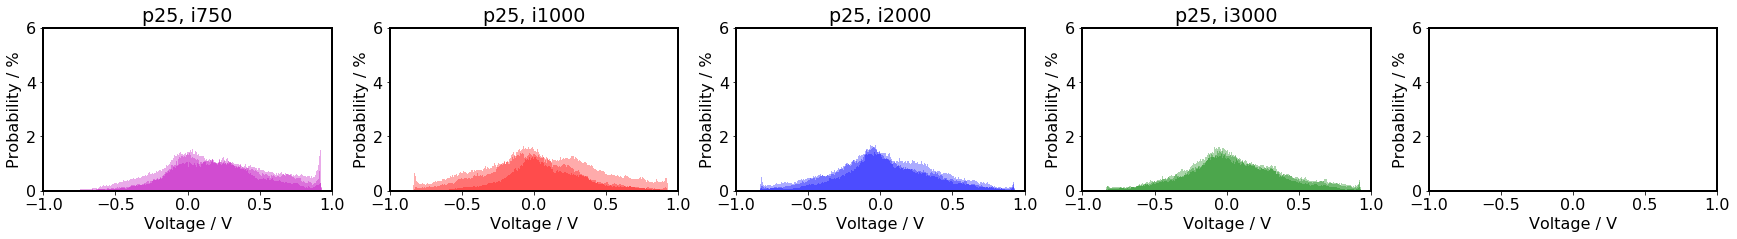

In [111]:
# the histogram of the data
fig, ax = plt.subplots(1,5, figsize=(30,3))
ax[0].hist(df_voltage_pid_1[paths_p_1[10]], 500, density=True, facecolor='m', alpha=0.33)
ax[0].hist(df_voltage_pid_2[paths_p_2[10]], 500, density=True, facecolor='m', alpha=0.33)
ax[0].hist(df_voltage_pid_3[paths_p_3[10]], 500, density=True, facecolor='m', alpha=0.33)
ax[0].set_title('p25, i750')
ax[1].hist(df_voltage_pid_1[paths_p_1[11]], 500, density=True, facecolor='r', alpha=0.33)
ax[1].hist(df_voltage_pid_2[paths_p_2[11]], 500, density=True, facecolor='r', alpha=0.33)
ax[1].hist(df_voltage_pid_3[paths_p_3[11]], 500, density=True, facecolor='r', alpha=0.33)
ax[1].set_title('p25, i1000')
ax[2].hist(df_voltage_pid_1[paths_p_1[12]], 500, density=True, facecolor='b', alpha=0.33)
ax[2].hist(df_voltage_pid_2[paths_p_2[12]], 500, density=True, facecolor='b', alpha=0.33)
ax[2].hist(df_voltage_pid_3[paths_p_3[12]], 500, density=True, facecolor='b', alpha=0.33)
ax[2].set_title('p25, i2000')
ax[3].hist(df_voltage_pid_1[paths_p_1[13]], 500, density=True, facecolor='g', alpha=0.33)
ax[3].hist(df_voltage_pid_2[paths_p_2[13]], 500, density=True, facecolor='g', alpha=0.33)
ax[3].hist(df_voltage_pid_3[paths_p_3[13]], 500, density=True, facecolor='g', alpha=0.33)
ax[3].set_title('p25, i3000')
#ax[4].hist(df_voltage_pid_1[paths_p_1[9]], 500, density=True, facecolor='y', alpha=0.33)
#ax[4].hist(df_voltage_pid_2[paths_p_2[9]], 500, density=True, facecolor='y', alpha=0.33)
#ax[4].hist(df_voltage_pid_3[paths_p_3[9]], 500, density=True, facecolor='y', alpha=0.33)
#ax[4].set_title('p25, i500')

#set same x,y limits for all subplots
for i, subplot in np.ndenumerate(ax):
    subplot.set_xlim(-1, 1)
    subplot.set_ylim(0,6)
    subplot.set_xlabel('Voltage / V')
    subplot.set_ylabel('Probability / %')

plt.show()

In [86]:
def GaussianFWHM(n, bins): 
    fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)+p[3]
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    
    #fit
    xdata    = bins[1:]
    ydata    = n
    init  = [1.0, 0.5, 0.5, 0.5]

    out   = leastsq(errfunc, init, args=(xdata, ydata))
    c = out[0]
    
    # Plot fit
    #plot(xdata, fitfunc(c, xdata), 'r')
    
    spline = UnivariateSpline(xdata, fitfunc(c, xdata)-np.max(fitfunc(c, xdata))/2, s=0)
    r1, r2 = spline.roots() # find the roots
    FWHM = abs(r2-r1)
    
    return(FWHM)

In [95]:
# Optimize and calculate mean of optimized parameters
FWHMs = pd.DataFrame()

#for i in range(len(paths_p_1)):
for i in range(3,15):
    #create hist
    n_1, bins_1, patches_1 = plt.hist(df_hist_p_01.iloc[:, i], 500, density=True, facecolor='r', alpha=0.33)
    n_2, bins_2, patches_2 = plt.hist(df_hist_p_02.iloc[:, i], 500, density=True, facecolor='b', alpha=0.33)
    n_3, bins_3, patches_3 = plt.hist(df_hist_p_03.iloc[:, i], 500, density=True, facecolor='g', alpha=0.33)
    
    fwhm_1 = GaussianFWHM(n_1, bins_1)
    fwhm_2 = GaussianFWHM(n_2, bins_2)
    fwhm_3 = GaussianFWHM(n_3, bins_3)
    
    FWHMs[i]=[fwhm_1, fwhm_2, fwhm_3]
    
    #print(i)
    
#print("Done.")
plt.close()

3
4
5
6
7
8
9
10
11
12
13
14
Done.


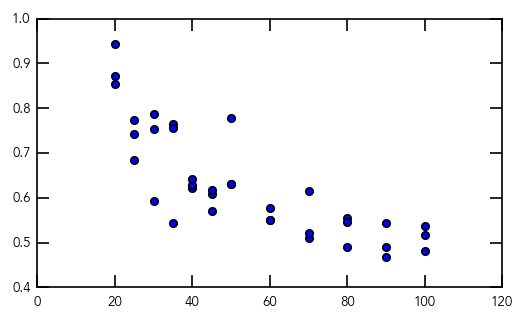

In [96]:
y1 = FWHMs[:1]
y2 = FWHMs[1:2]
y3 = FWHMs[2:3]
x = np.array([20,25,30,35,40,45,50,60,70,80,90,100])

plt.scatter(x, y1)
plt.scatter(x, y2)
plt.scatter(x, y3)

In [97]:
FWHMs = FWHMs.rename(columns={3: 'p20',
                              4: 'p25',
                              5: 'p30',
                              6: 'p35',
                              7: 'p40',
                              8: 'p45',
                              9: 'p50',
                              10: 'p60',
                              11: 'p70',
                              12: 'p80',
                              13: 'p90',
                              14: 'p100'}) 

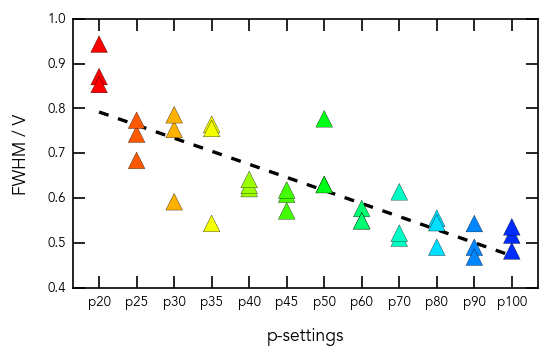

In [122]:
fig, ax = plt.subplots(1,1)

df_test = pd.DataFrame()
df_test['0'] = [0,0,0]
df = df_test.join(FWHMs, how='inner')

#y1 = df[:1].values[0]
#y2 = df[1:2].values[0]
#y3 = df[2:3].values[0]

#x=df.keys()

y1 = FWHMs[:1].values[0]
y2 = FWHMs[1:2].values[0]
y3 = FWHMs[2:3].values[0]


y_mean = FWHMs.mean()
x_mean=range(0,len(y_mean))
coef = np.polyfit(x_mean,y_mean,1)
poly1d_fn = np.poly1d(coef) 

x=FWHMs.keys()

c=[]
for i in range(0,12):
    c.append(colors[i])
    
#ax.boxplot(data, showmeans=False, meanline=True, showbox=True, showcaps=False, showfliers=False)
#FWHMs.boxplot(ax=ax, showmeans=False, meanline=False, showbox=False, showcaps=False, showfliers=False)

ax.plot(x, poly1d_fn(x_mean), '--k', zorder=-1)
ax.scatter(x, y1, marker='^', s=100, c=c, linewidth=0.2)
ax.scatter(x, y2, marker='^', s=100, c=c, linewidth=0.2)
ax.scatter(x, y3, marker='^', s=100, c=c, linewidth=0.2)

plt.style.use('ITWM')
#plt.rcParams["figure.figsize"] = (15,10)
plt.ylim([0.4,1])
plt.xlabel('p-settings', fontsize=10.5)
plt.ylabel('FWHM / V', fontsize=10.5)
#plt.title("FWHMs of RF-histograms for different p-settings (i = 3000)")
#plt.grid(alpha=0.8)


## Edit the major and minor ticks of the x and y axes
#ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
#ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
#ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
#ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

# Edit the font, font size, and axes width
#mpl.rcParams['font.family'] = 'Amiri'
#plt.rcParams['font.size'] = 18
#plt.rcParams['axes.linewidth'] = 2
#ax.title.set_position([.5, 1.03])


#plt.scatter(x, y, c=t, cmap='viridis')
#plt.colorbar()

plt.savefig('FWHMs')
plt.savefig('FWHMs.pdf', format='pdf')

plt.show()